In [1]:
import os
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
import datetime as dt
from dataset.electricity_dataset import electricity_pre
from datetime import datetime
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
import random

In [2]:
warnings.filterwarnings('ignore')
now = datetime.now()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
#for debugging
gc =0
GC=[]

In [4]:
np.set_printoptions(precision=4)

In [5]:
#generating Hierarchy aggregation matrix for tourism dataset
ht,hir=[],[[0,56],[0,14],[14,28],[28,42],[42,56]]
for i in range(0,56,2):
    hir.append([i,i+2])
for i in hir:
    ht.append([i[0]+33,i[1]+33])
# aggregation matrix
AG=np.zeros([33,56])    
for j,i in zip(ht,range(34)):
    AG[i][j[0]-33:j[1]-33]=1     
AG    

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [6]:
data = pd.read_csv("tourism.csv") 

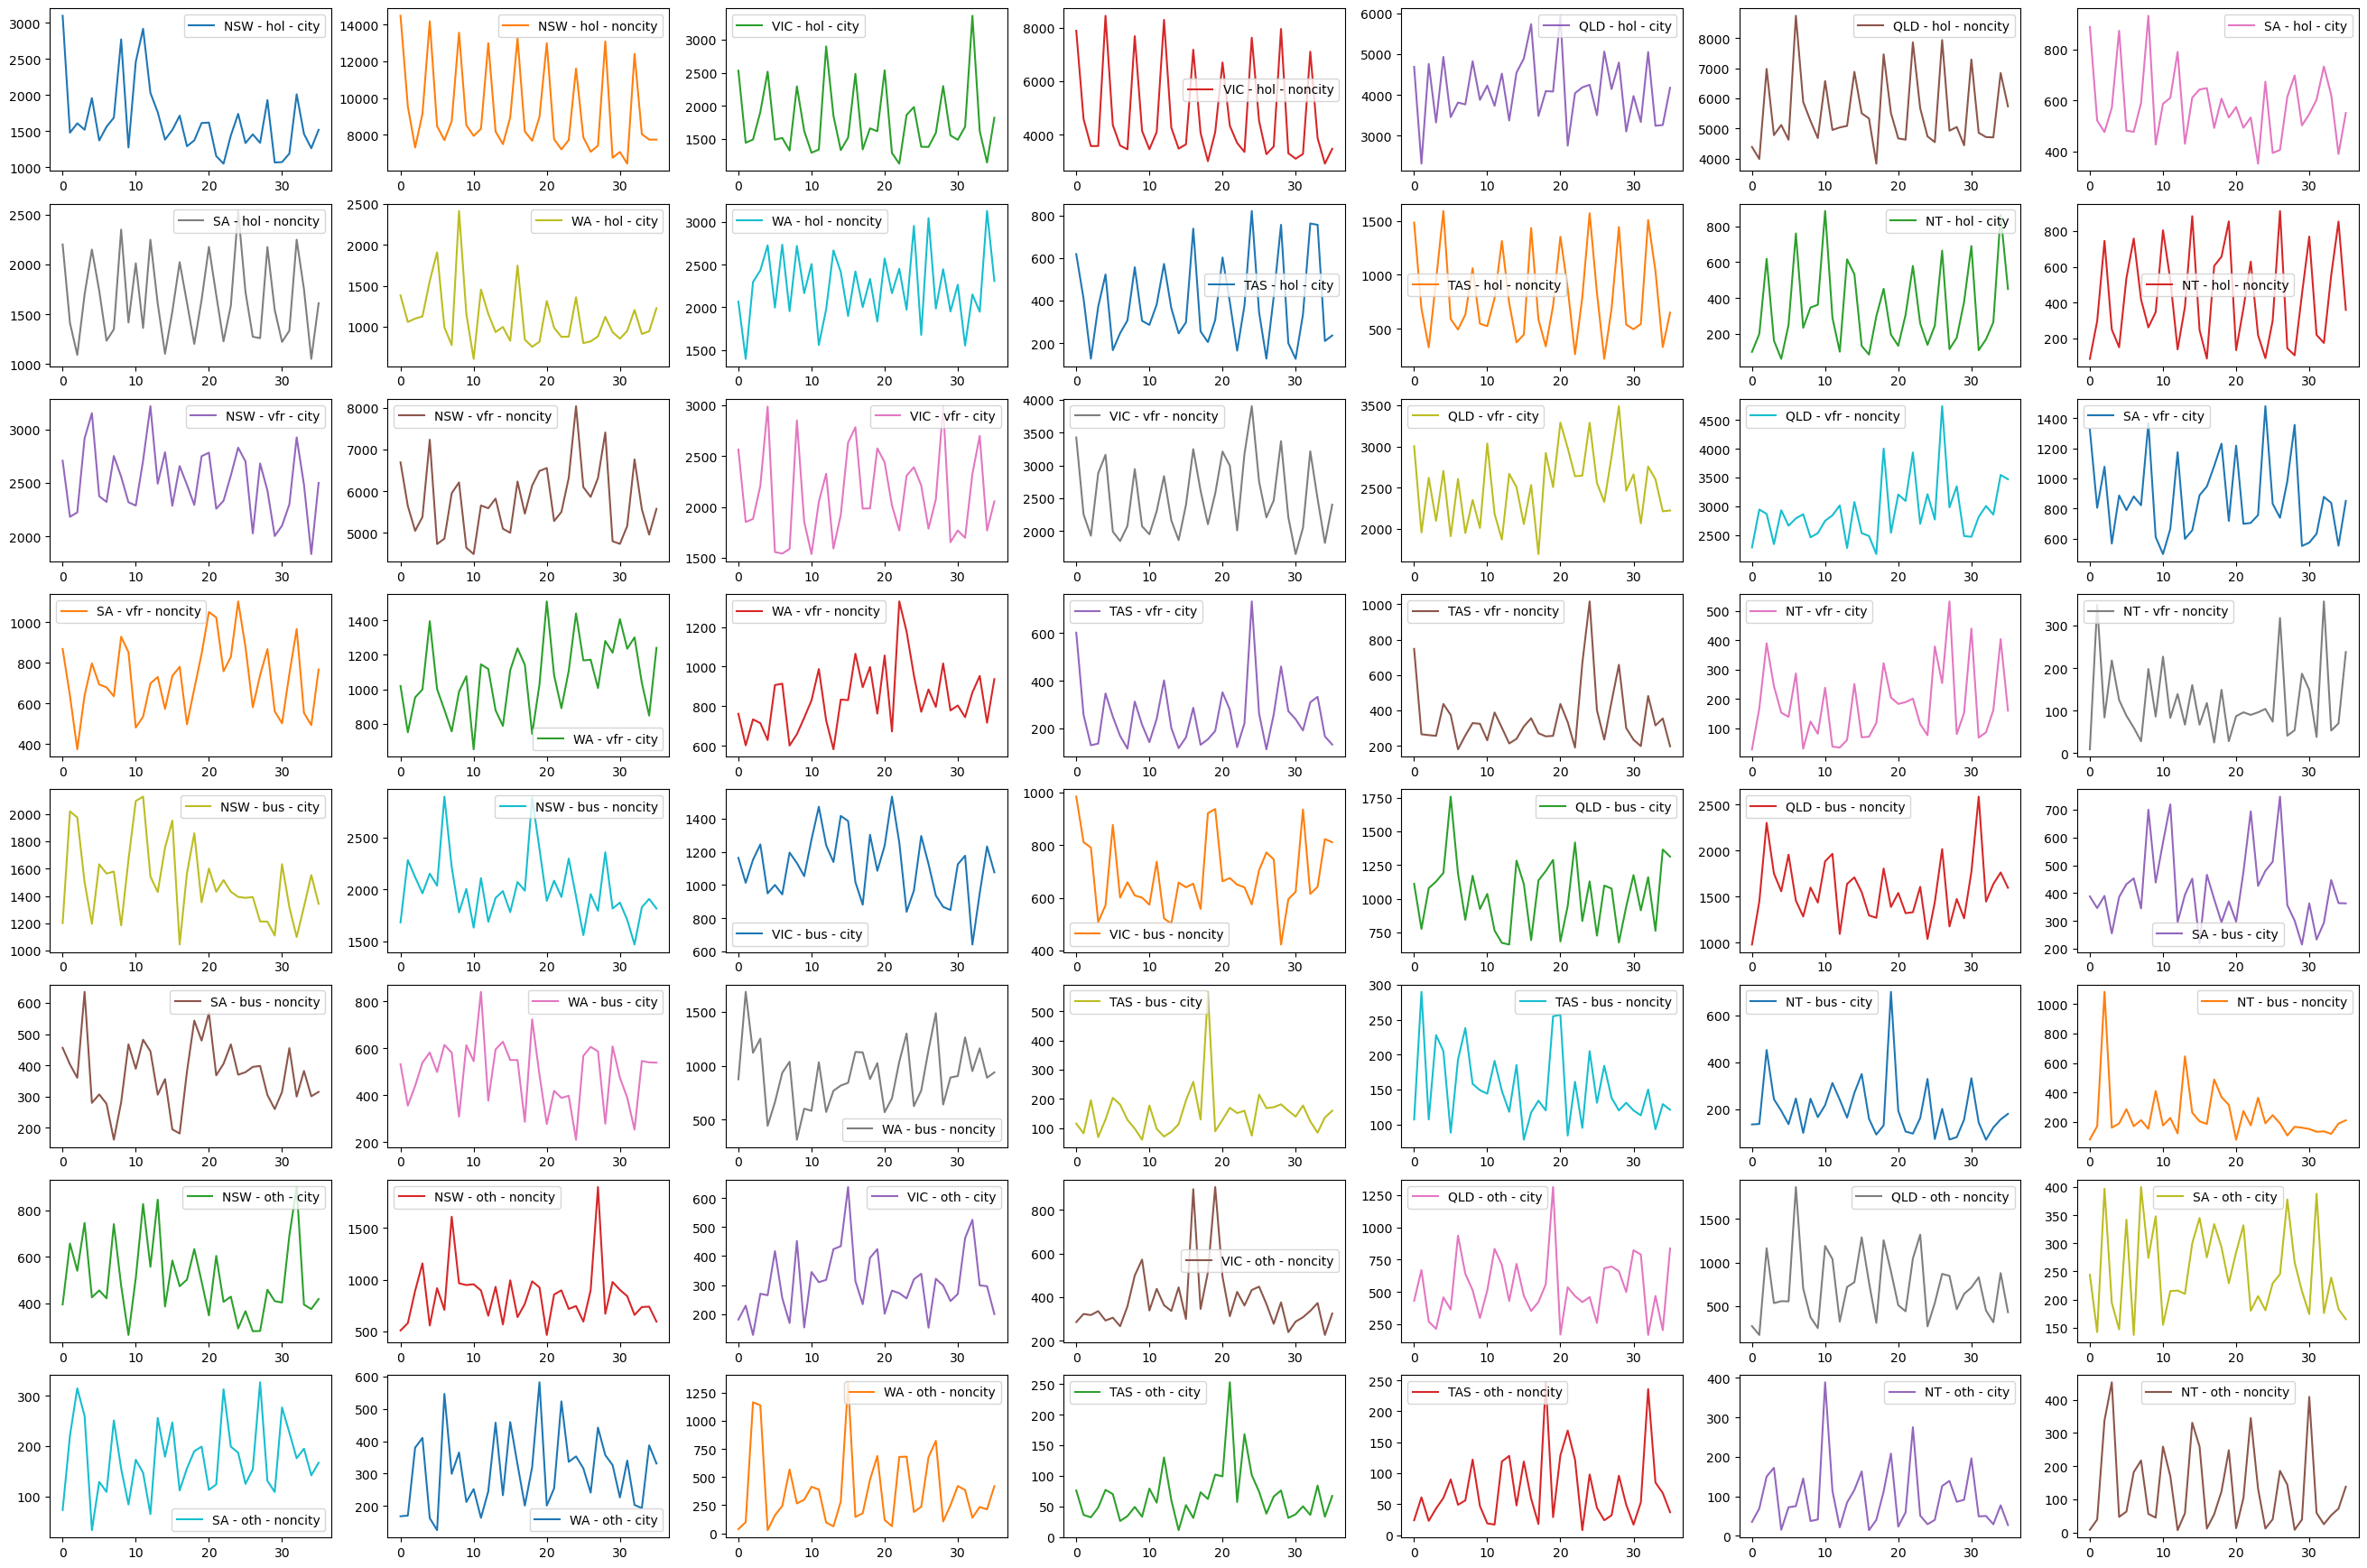

In [7]:
bottom=list(data.iloc[:,-56:].columns.values)
fig, axes = plt.subplots(nrows=8, ncols=7,figsize=(33,22))
data[data.columns.intersection(bottom)].plot(subplots=True, ax=axes)
plt.plot();

In [8]:
#  probabalistic model with likelihood function
class model(nn.Module):
    def __init__(self, num_lstms, input_dim, output_dim=1, hidden_dim=64):
        super(model, self).__init__()
        self.lstm_out = hidden_dim
        self.num_lstms = num_lstms
        lstms = []
        lstms.append(nn.LSTMCell(input_dim, self.lstm_out))
        for i in range(1, self.num_lstms):
            lstms.append(nn.LSTMCell(self.lstm_out, self.lstm_out))
        self.lstms = nn.ModuleList(lstms)
        # μ and σ  distibution -> next point for every t_i.prediction length is from output dimensions
        self.mean = nn.Linear(self.lstm_out, output_dim)
        self.std = nn.Linear(self.lstm_out, output_dim)
        
    def forward(self, input, covariates, future = 0):
        dev = input.device
        means = torch.Tensor().to(dev)
        stds = torch.Tensor().to(dev)
        outputs = []
        h_t = []
        c_t = []
        cond_ctx_len = input.size(1)
        pred_ctx_len = future
        #for covariartes concat input and covariates
        if covariates.shape[2] != 0:
            input = torch.cat((input, covariates[:, 0:cond_ctx_len, :]), 2)
        for i in range(0, self.num_lstms):
            h_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
            c_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
        '''
         h(hidden state),c(cell state)-> output of Lstm cell, h(i)-> passed to lstm(i+1) cell, 
         h(i) and c(i) are recurrent for lstm cell(i+1) 
         and the output from previous cell '''
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t[0], c_t[0] = self.lstms[0](input_t.squeeze(1), (h_t[0], c_t[0])) #first cell ->concat of input and covariates, recurrent input 
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))#susquent cells-> prev. output from stack, recurrent input
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        stds = self.softplus(stds)
       
        for i in range(future):
            output_t = torch.cat((mean, covariates[:, cond_ctx_len + i, :]), 1)
            h_t[0], c_t[0] = self.lstms[0](output_t, (h_t[0], c_t[0]))
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            std = self.softplus(std) # avoid infinties
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        means = means.unsqueeze(-1)
        stds = stds.unsqueeze(-1)
        outputs = torch.cat((means, stds), -1)
        return outputs

    def sample(self, mean, std):
        normal_dist = torch.distributions.normal.Normal(mean, std)
        return normal_dist.sample()

    def softplus(self, x):
        softplus = torch.log(1+torch.exp(x))
        softplus = torch.where(softplus==float('inf'), x, softplus)
        return softplus

    def NLL(self, outputs, truth,AG):#negative log liklihood
        hierarchy_tot,bottom_tot=AG.shape
        mean, std = torch.split(outputs, 1, dim=3)
        AG_tensor= torch.from_numpy(AG)    
        mean = mean.squeeze(3)
        std = std.squeeze(3)
        std=std
        #bottom value calculation
        bottom_mean= mean[:, :, -bottom_tot:]
        bottom_std=std[:, :, -bottom_tot:]
        #hierarchy value calculation
        Hierarchy_mean=torch.matmul(bottom_mean.float(),AG_tensor.T.float())
        Hierarchy_std=torch.matmul(bottom_std.float(),AG_tensor.T.float())
        #all values for loss calculation top values are hierarchy and lower values are bottom
        total_mean=torch.cat((Hierarchy_mean,bottom_mean),dim=2)
        total_std=torch.cat((Hierarchy_std,bottom_std),dim=2)
        torch.pi = torch.acos(torch.zeros(1)).item()
        loss = torch.mean((0.5*torch.log(2*torch.pi*(total_std**2)))+torch.div(torch.sub(total_mean,truth)**2, total_std**2))
        return loss
    


# using NLL
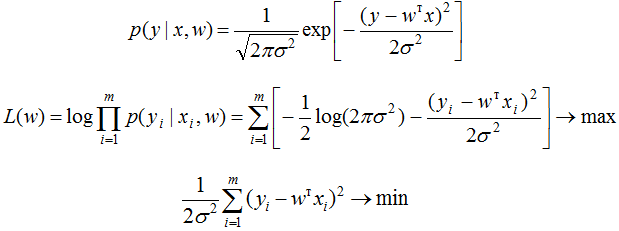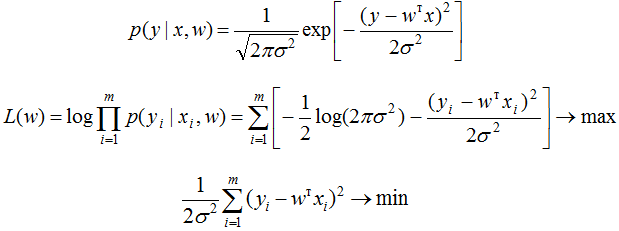

In [9]:
def date_cv(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [10]:
'''

_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': .1,
    'ctx_win_len': 22,
    'cond_win_len': 10,
    'batch_size': 512,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 89,
    'total_num_targets': 89,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch': 200,
    'num_epochs': 100,
    'data_file': 'trsv.csv',
    'train_test_split':0.7
}

'''

_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': 1,
    'ctx_win_len':10,
    'cond_win_len':8,
    'batch_size': 1024,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 89,
    'total_num_targets': 89,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch': 100,
    'num_epochs': 50,
    'data_file': 'trsv.csv',
    'train_test_split':0.7
}


In [11]:
class utils:
    def __init__(self, dev,_params):
        self.min = 0
        self.max = 0
        self.range = 0
        self.mean = 0
        self.dev = dev
        self._params = _params

    def split_batch(self, batch):
        num_time_idx = self._params['num_time_idx']
        num_targets = self._params['num_targets']
        total_num_targets = self._params['total_num_targets']
        num_covariates = self._params['num_covariates']    
        b = num_time_idx
        time_idx = batch[:, 1::, :b].to(self.dev).float()
        e = b + num_targets
        input = batch[:, 0:-1, b: e].to(self.dev).float()
        target = batch[:, 1::, b: e].to(self.dev).float()
        e = e - num_targets + total_num_targets
        total_num_covariates = batch.shape[2] - e + 1  
        covariates = time_idx
        b = e
        e = b + num_covariates
        if (num_covariates > 0):
            covariates = torch.cat((time_idx, batch[:, 1::, b: e]), -1)
        return input, target, covariates

    def scale(self, input, covariates):
        
        self.mean = torch.mean(input, dim=1).unsqueeze(1)
        input = input - self.mean
        min = torch.min(input, dim=1)[0].unsqueeze(1)
        max = torch.max(input, dim=1)[0].unsqueeze(1)
        self.range = max - min
        self.range[self.range < 1e-5] = 1e-5
        input = input / self.range

        num_covariates = self._params['num_covariates']
        if (num_covariates > 0):
            mean = torch.mean(covariates, dim=1).unsqueeze(1)
            covariates = covariates - mean
            min = torch.min(covariates, dim=1)[0].unsqueeze(1)
            max = torch.max(covariates, dim=1)[0].unsqueeze(1)
            range = max - min
            range[range < 1e-5] = 1e-5
            covariates = covariates / range
        return input, covariates

    def invert_scale(self, input, probabalistic=False):
        if probabalistic == False:
            return input * self.range + self.mean
        else:
            mean = input[:, :, :, 0]
            std = input[:, :, :, 1]
            scaled_mean = mean * self.range + self.mean
            scaled_std = std * torch.sqrt(self.range)
            return torch.cat((scaled_mean.unsqueeze(-1), scaled_std.unsqueeze(-1)), -1)

In [12]:
data.dtypes

Total                  int64
Hol                    int64
VFR                    int64
Bus                    int64
Oth                    int64
                       ...  
WA - oth - noncity     int64
TAS - oth - city       int64
TAS - oth - noncity    int64
NT - oth - city        int64
NT - oth - noncity     int64
Length: 89, dtype: object

In [13]:
data.to_csv('dataset/trsv.csv')

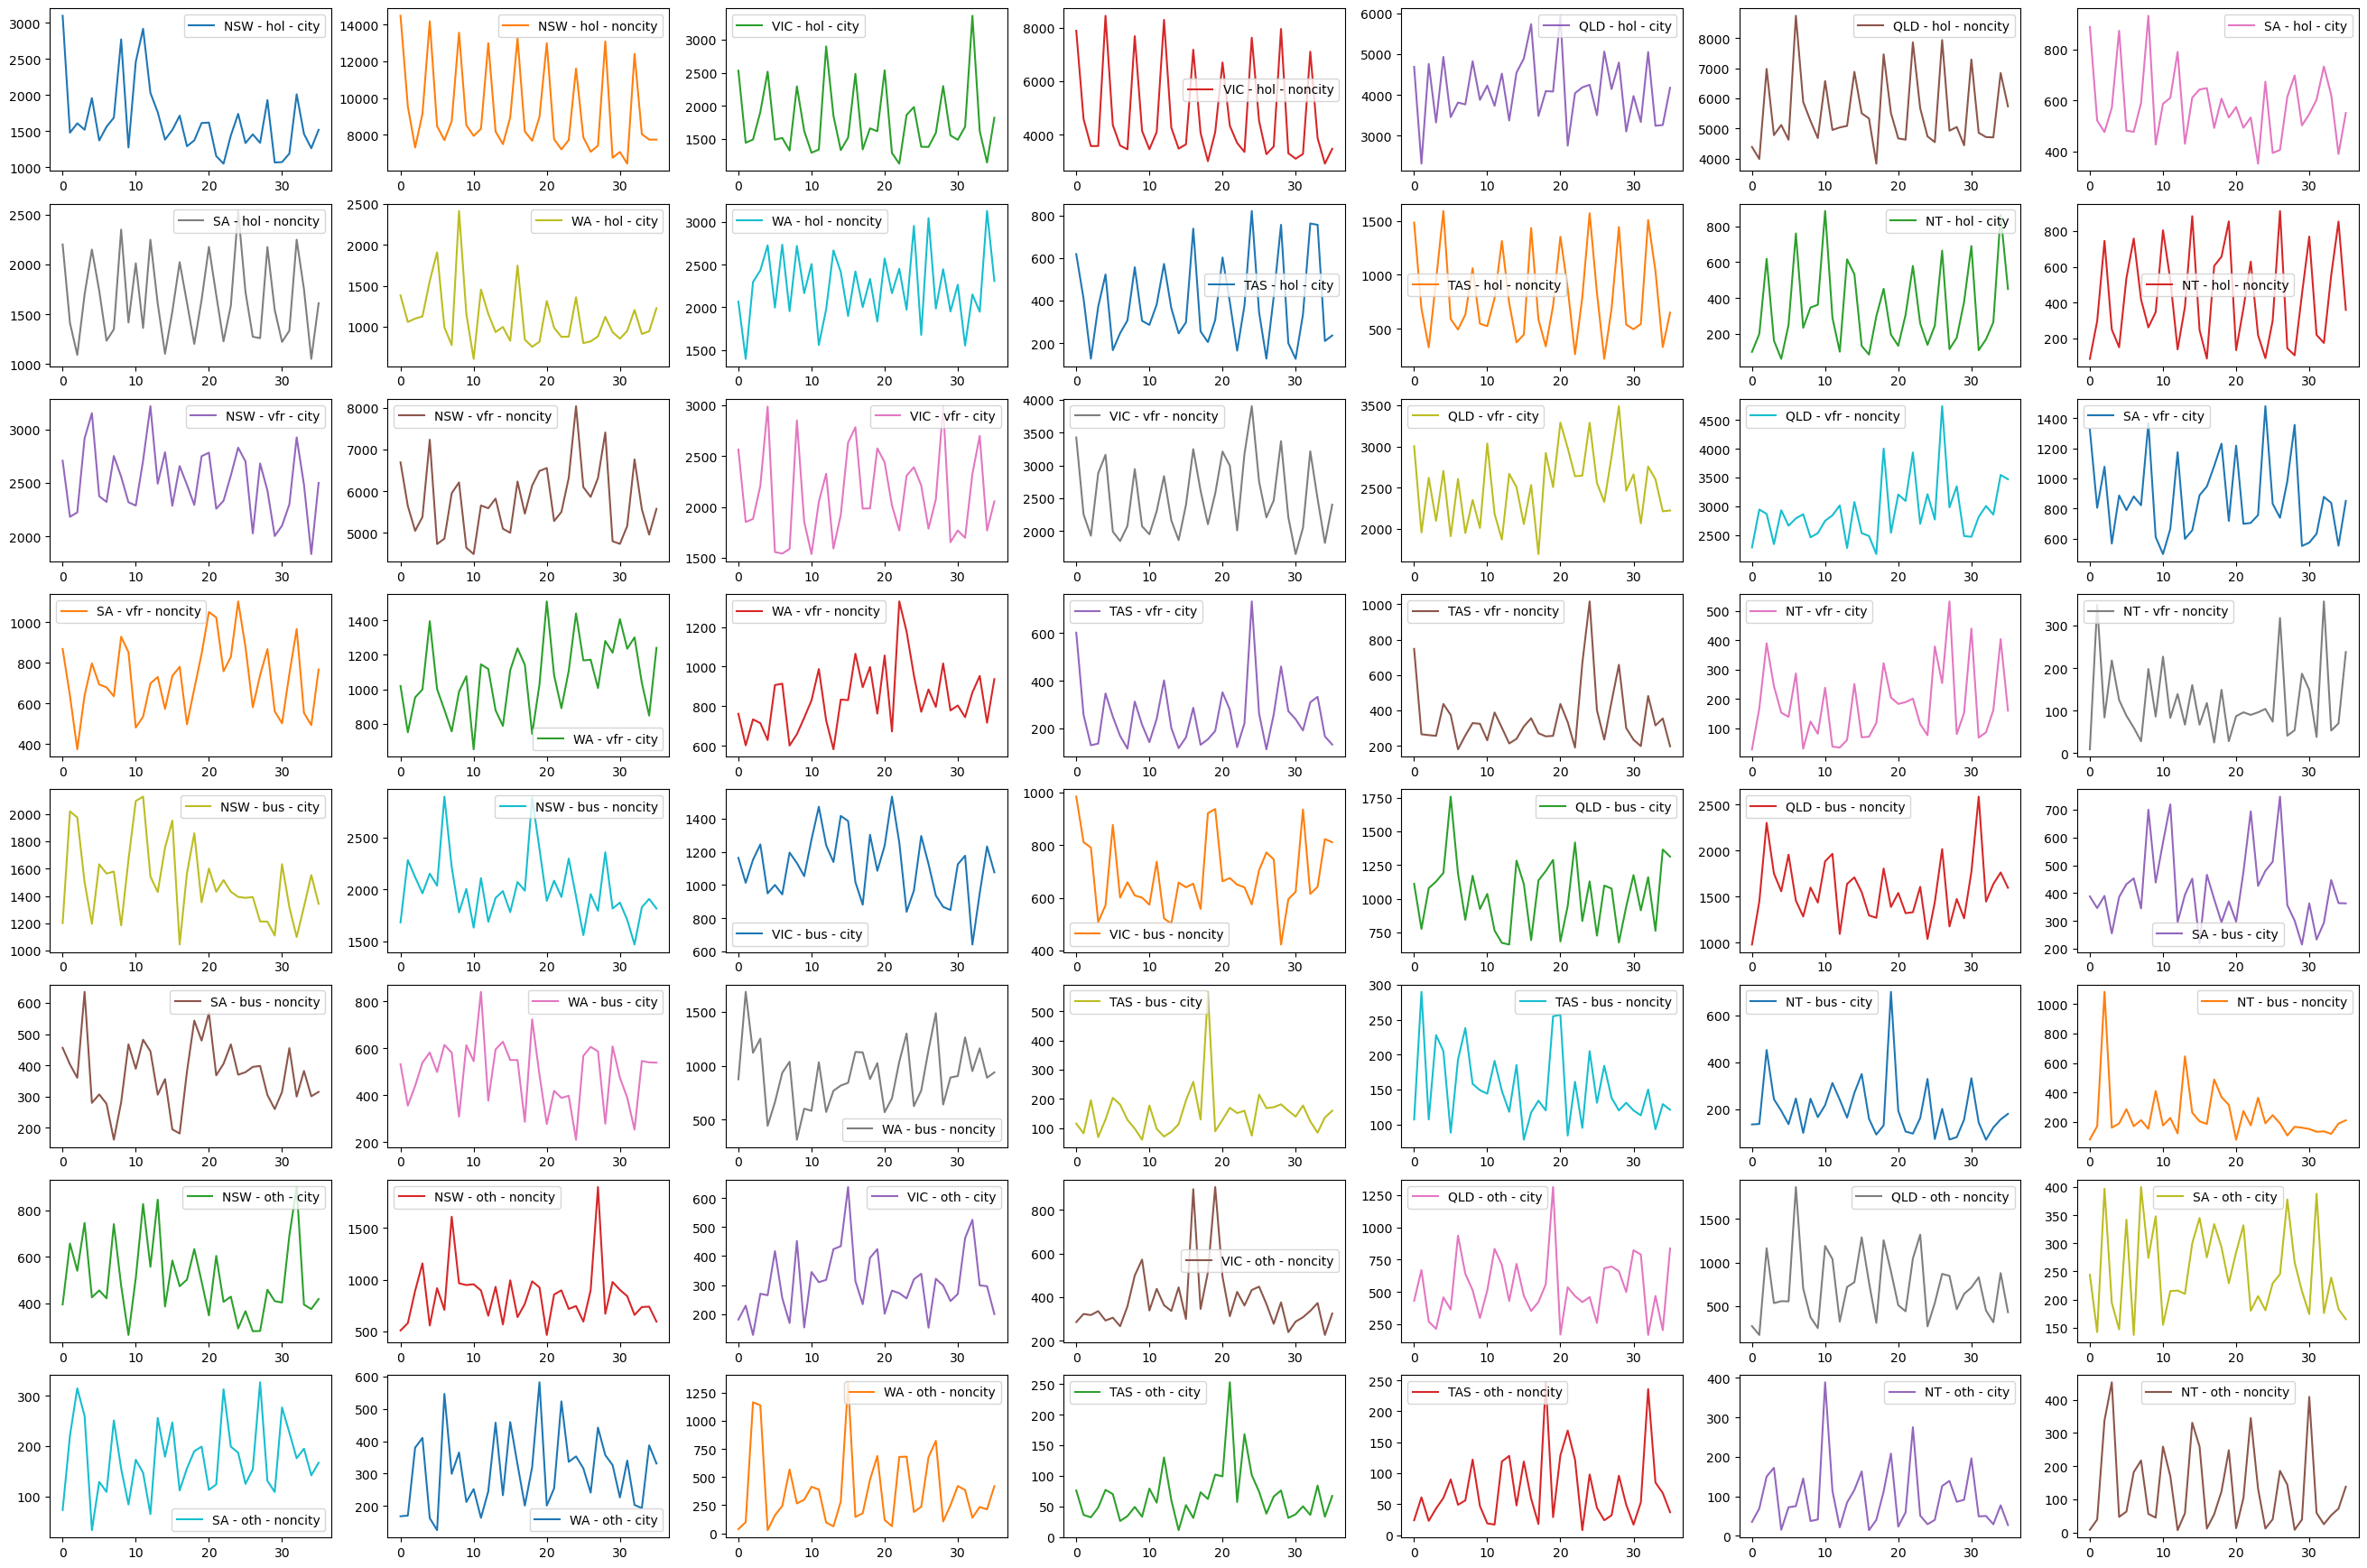

In [14]:
fig, axes = plt.subplots(nrows=8, ncols=7,figsize=(33,22))
data[data.columns.intersection(bottom)].plot(subplots=True, ax=axes)
plt.plot();

In [15]:
class MyDataset(Dataset):
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        rel_time = torch.from_numpy(np.arange(0, self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(self.dev)
        abs_time = torch.from_numpy(np.arange(idx, idx + self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(
            self.dev)
        if (self.num_time_indx == 2):  
            out = torch.cat((rel_time, abs_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 1):  
            out = torch.cat((rel_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 0):  
            out = self.scaled[idx: idx + self.ctx_win_len, :].unsqueeze(0)
        return torch.squeeze(out, 0)
    
    def get_train_test_samplers(self, train_test_split):
        indices = list(range(self.dataset_size))
        print
        split = int(np.floor(train_test_split * self.dataset_size))
        train_indices, test_indices = indices[: split - self.ctx_win_len], indices[split: -self.ctx_win_len]
        return SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)
    def plot_corr(self, df, size=10):
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(size, size))
        ax.matshow(corr)
        plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
        plt.yticks(range(len(corr.columns)), corr.columns)


In [16]:
class Tourism_pre(MyDataset):
    def __init__(self, csv_file, dev, ctx_win_len, num_time_indx=1):
        self.num_time_indx = num_time_indx
        self.dev = dev
        df = read_csv('dataset/trsv.csv',index_col=0)
        self.ctx_win_len = ctx_win_len
        values = df.values
        values = values.astype('float32')
        self.scaled = values
        self.dataset_size = self.scaled.shape[0]
        self.scaled = torch.from_numpy(self.scaled).float().to(dev)
        self.resolution = 1

In [17]:
params = _params_
dataset_ = Tourism_pre(csv_file=params['data_file'], dev=device, ctx_win_len=params['ctx_win_len'], num_time_indx=params['num_time_idx'])

In [18]:
num_covariates = params['num_covariates']
num_time_idx = params['num_time_idx']
num_targets = params['num_targets']
input_dim = num_time_idx + num_targets + num_covariates
ctx_win_len = params['ctx_win_len']
cond_win_len = params['cond_win_len']
pred_win_len = ctx_win_len - cond_win_len - 1
batch_size = params['batch_size']

In [19]:
model = model(num_lstms=params['num_lstms'], input_dim=input_dim, output_dim=params['num_targets'],hidden_dim=params['hidden_dim']).to(device)
optimizer = optim.Adam(model.parameters(), params['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_step_size'], gamma=params['lr_gamma'])

In [20]:
train_sampler, test_sampler = dataset_.get_train_test_samplers(params['train_test_split'])

In [21]:
train_dataloader = DataLoader(dataset_, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset_, batch_size=1, sampler=test_sampler,shuffle=False, num_workers=0)
max_batches_per_epoch = params['max_batches_per_epoch']
num_epochs = params['num_epochs']

In [22]:
losses = []
batch_num = 1
utils = utils(device, params)
# Trainin loop
def train():
    for epoch in range(0, num_epochs):
        batch_num = 0
        for i, batch in enumerate(train_dataloader):
            if batch_num > max_batches_per_epoch:
                break    
            input, target, covariates = utils.split_batch(batch) 
            #splitting batches : issue with sequence
            #conditioning window input,Prediction window , model op conditioned on previous values
            # model output for the previous step
            input_cond = input[:, 0:cond_win_len, :]
            input_cond, covariates = utils.scale(input_cond, covariates)
            optimizer.zero_grad()
            #forward pass
            out = model(input_cond, covariates, future=pred_win_len)
            out = utils.invert_scale(out, probabalistic=True)
            #rescale
            loss = model.NLL(out, target,AG)
            #loss calc
            loss.backward()
            scheduler.step()
            optimizer.step()
            loss = loss.item()
            losses.append(loss)
            print(f"epoch:{epoch} /{num_epochs}| batch:{batch_num}:loss:{loss}")
            batch_num = batch_num + 1
    return model, losses


In [23]:
model, losses = train()
data='elec'# electricity dataset
date_=str(now).replace(" ", "")
model_save_ = f"{data}_epochs{params['num_epochs']}_{ date_ }"
torch.save(model.state_dict(), model_save_+".pth")

epoch:0 /50| batch:0:loss:212.54515075683594
epoch:1 /50| batch:0:loss:188.80029296875
epoch:2 /50| batch:0:loss:161.60806274414062
epoch:3 /50| batch:0:loss:126.78044891357422
epoch:4 /50| batch:0:loss:87.76004791259766
epoch:5 /50| batch:0:loss:58.22498321533203
epoch:6 /50| batch:0:loss:42.07940673828125
epoch:7 /50| batch:0:loss:32.083805084228516
epoch:8 /50| batch:0:loss:25.126201629638672
epoch:9 /50| batch:0:loss:19.252275466918945
epoch:10 /50| batch:0:loss:15.608774185180664
epoch:11 /50| batch:0:loss:13.241806030273438
epoch:12 /50| batch:0:loss:11.638269424438477
epoch:13 /50| batch:0:loss:10.556913375854492
epoch:14 /50| batch:0:loss:9.748551368713379
epoch:15 /50| batch:0:loss:9.119367599487305
epoch:16 /50| batch:0:loss:8.665608406066895
epoch:17 /50| batch:0:loss:8.36369800567627
epoch:18 /50| batch:0:loss:8.155767440795898
epoch:19 /50| batch:0:loss:7.990926265716553
epoch:20 /50| batch:0:loss:7.8453521728515625
epoch:21 /50| batch:0:loss:7.713414669036865
epoch:22 /50

loss (prediction): 7.551730155944824


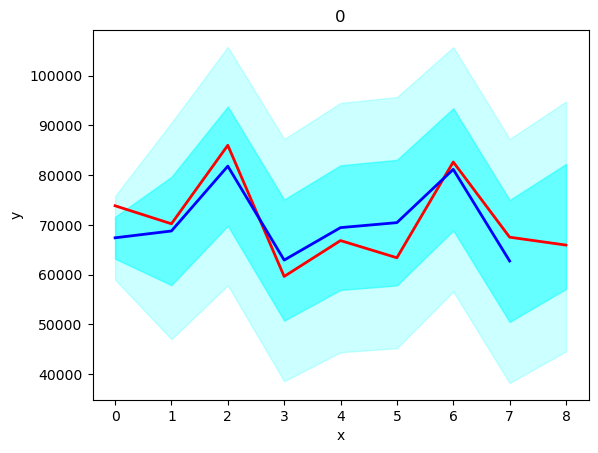

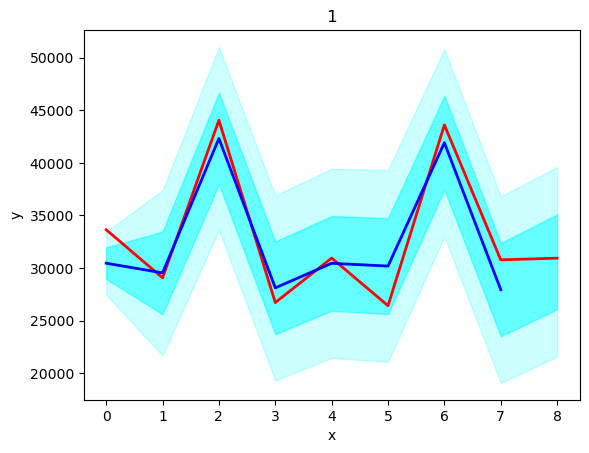

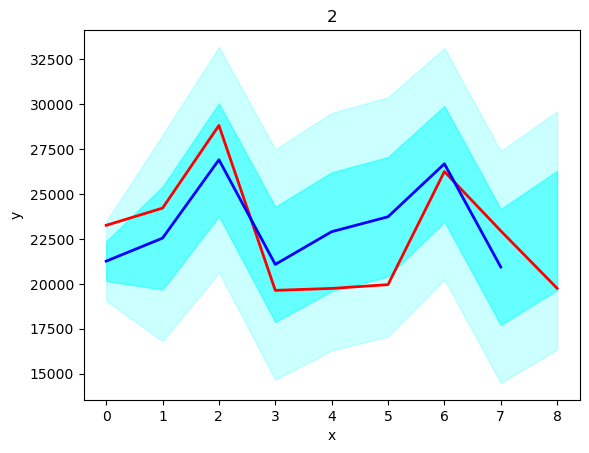

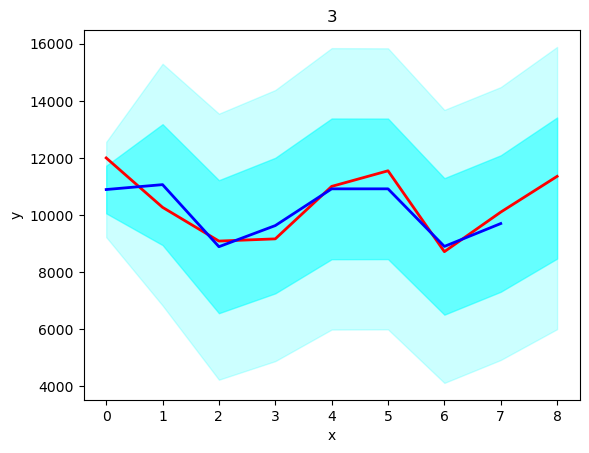

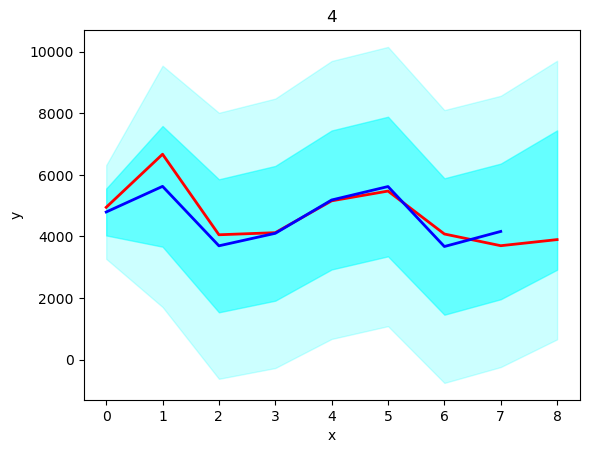

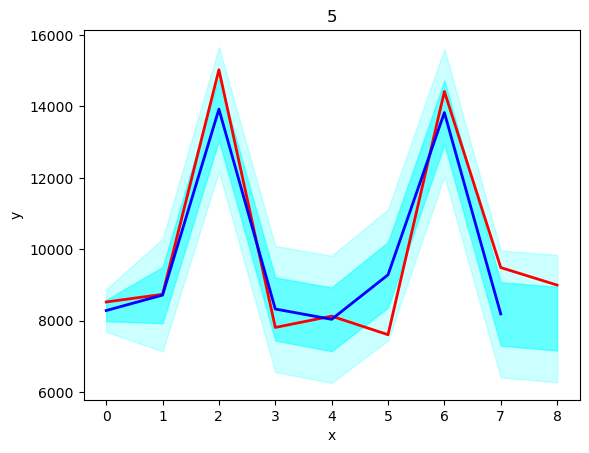

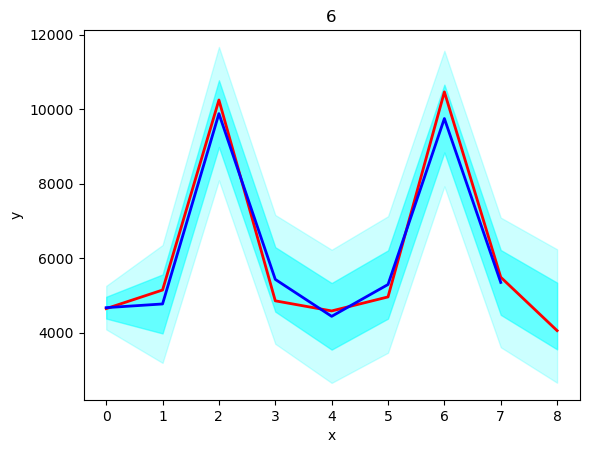

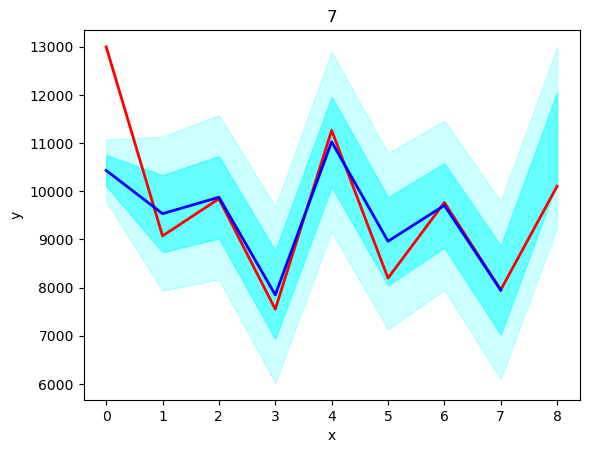

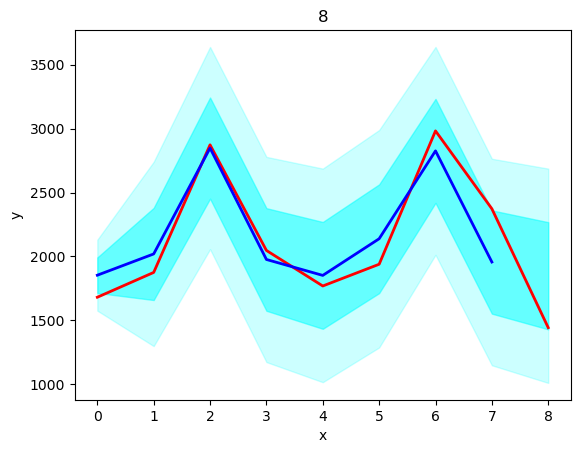

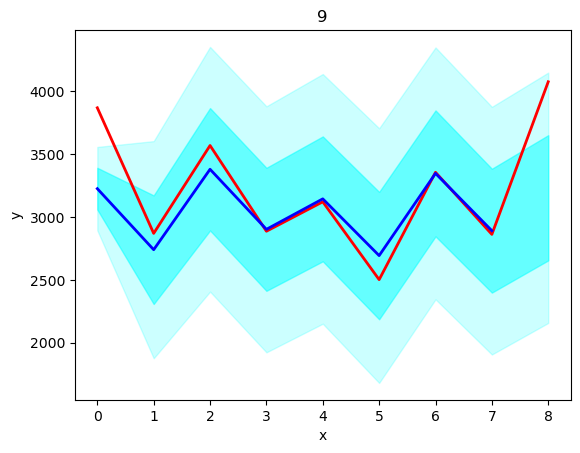

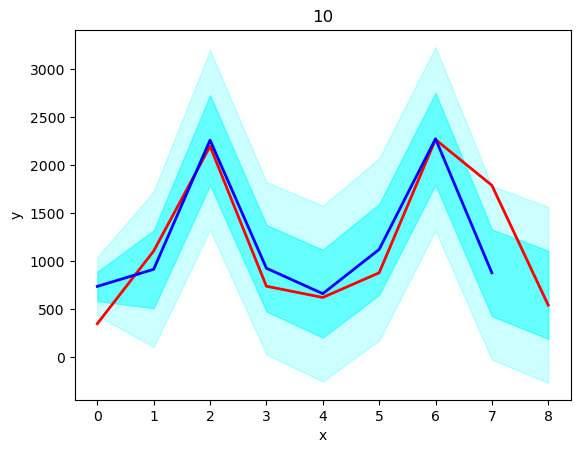

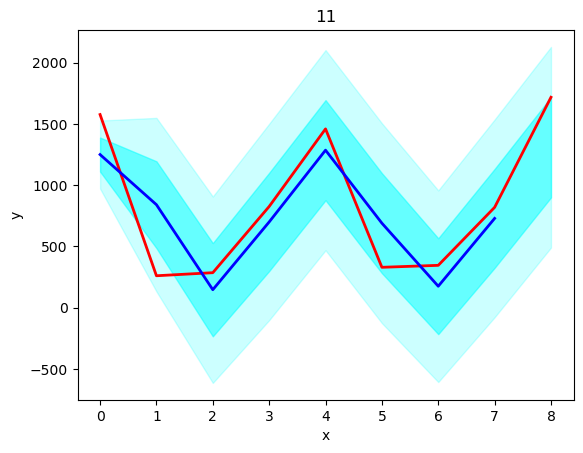

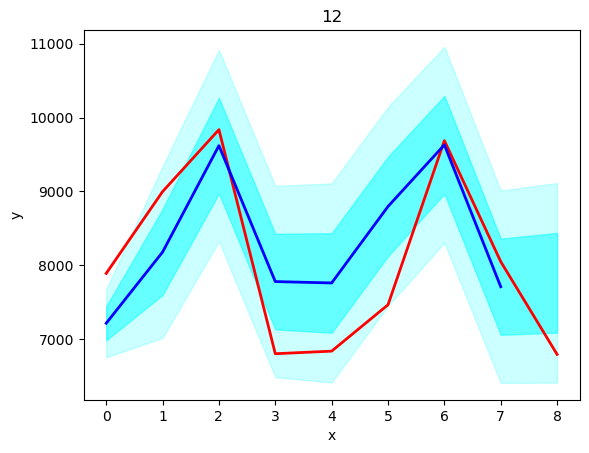

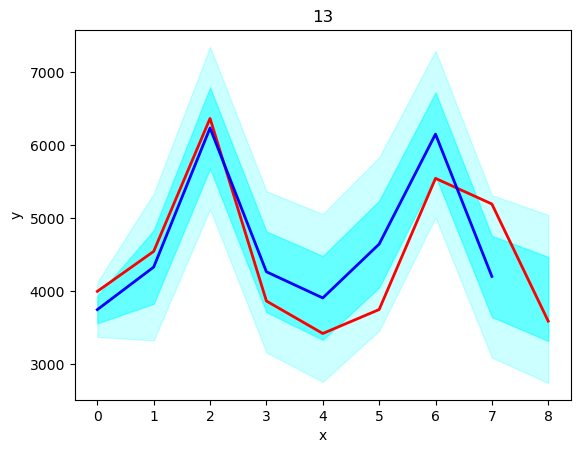

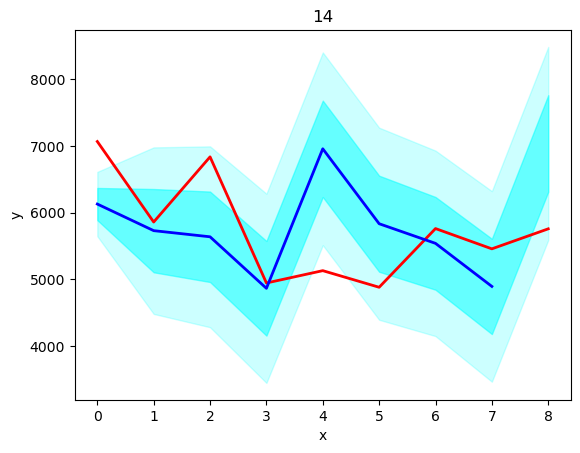

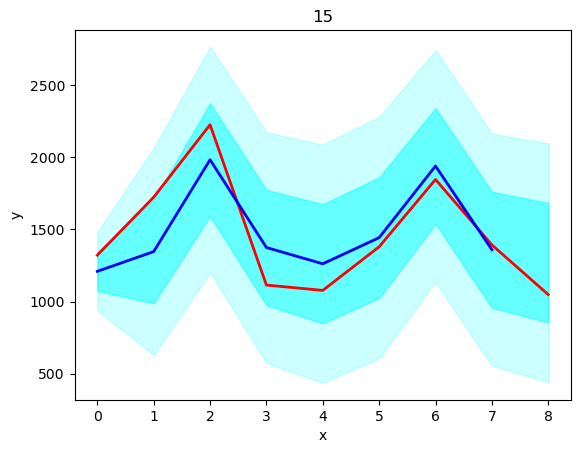

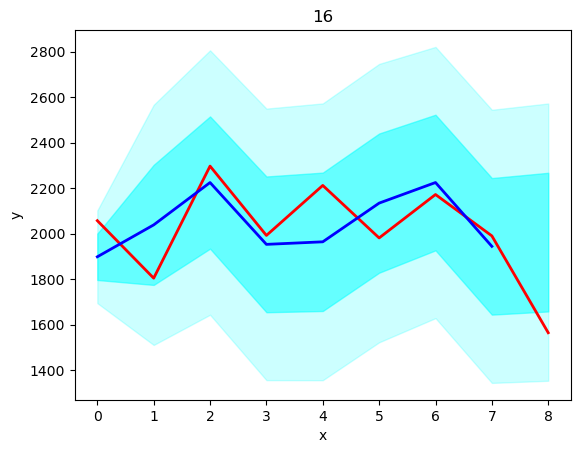

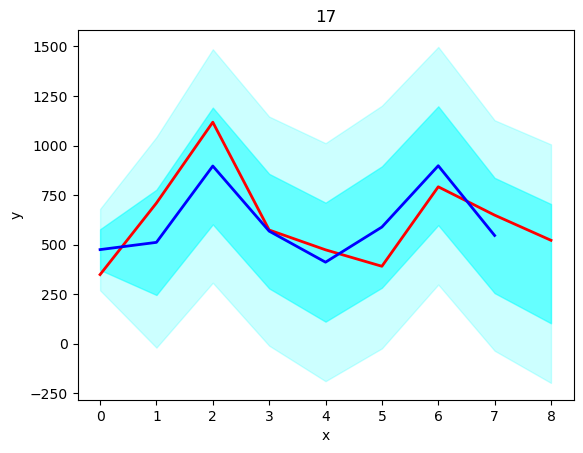

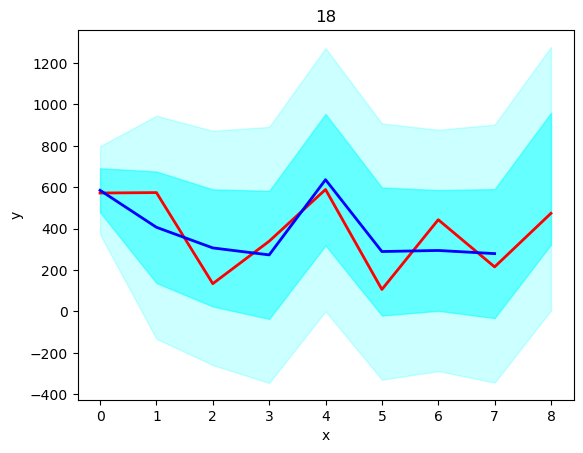

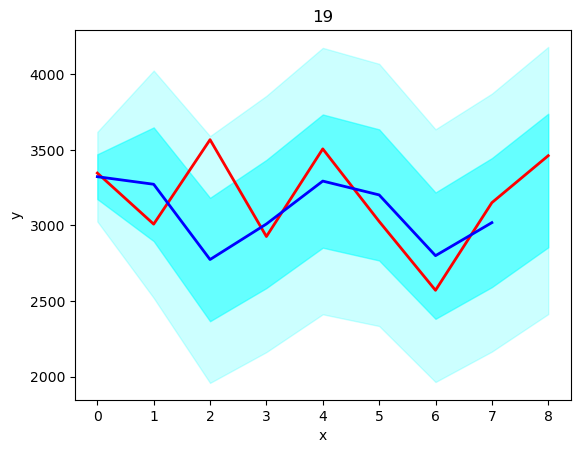

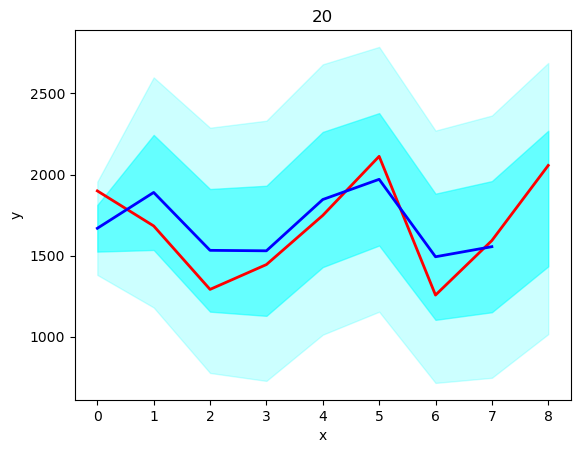

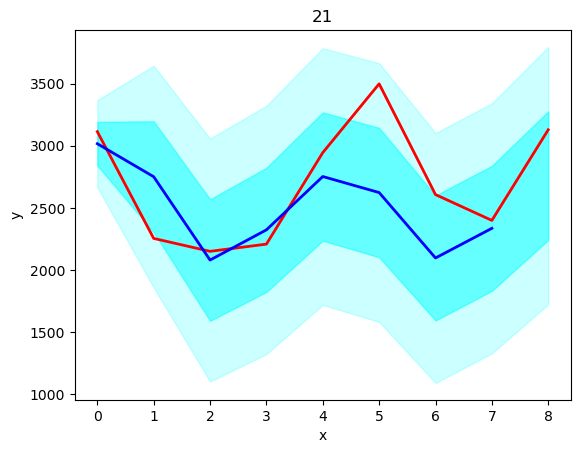

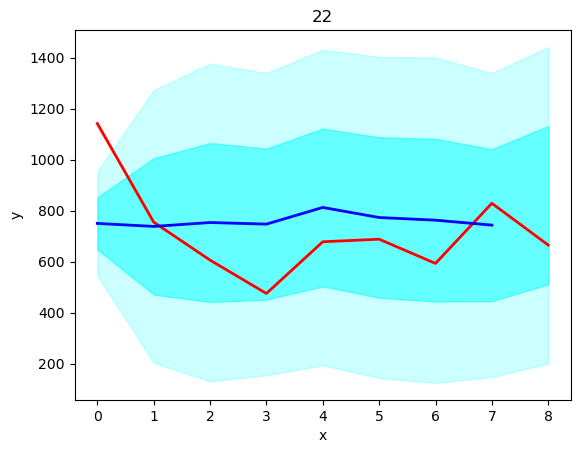

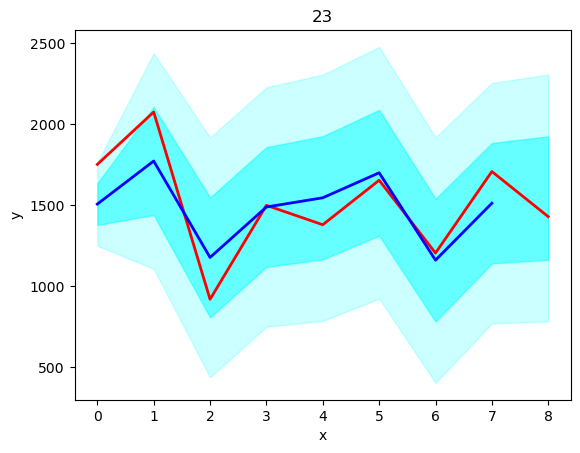

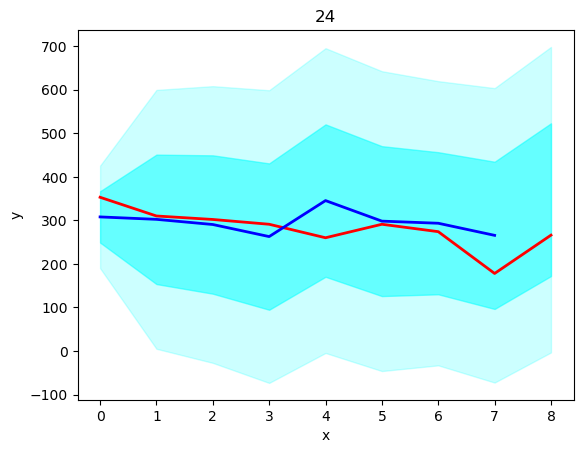

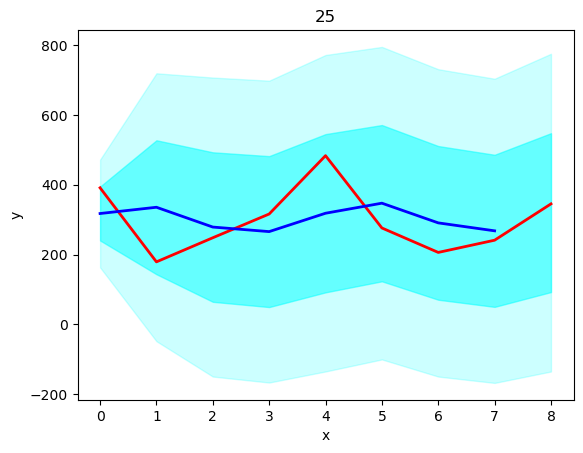

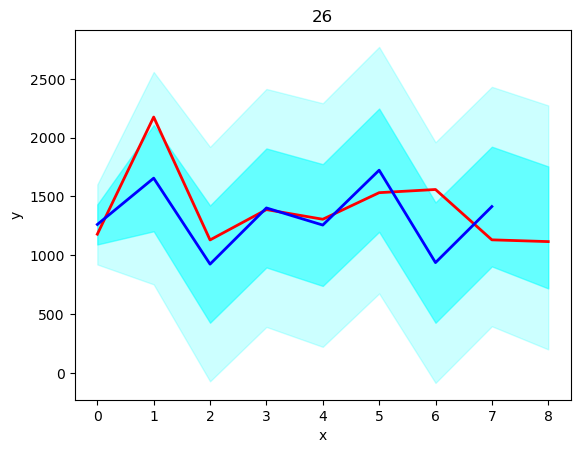

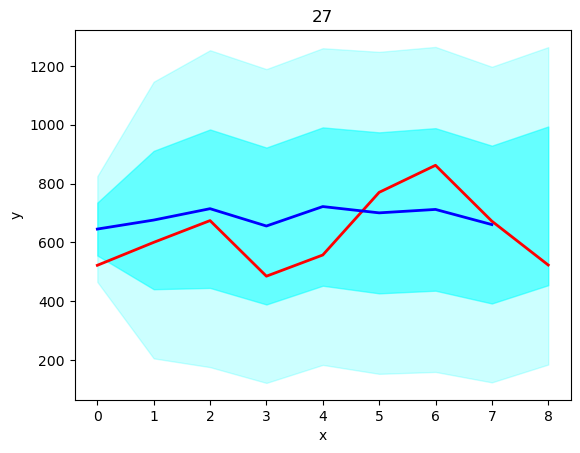

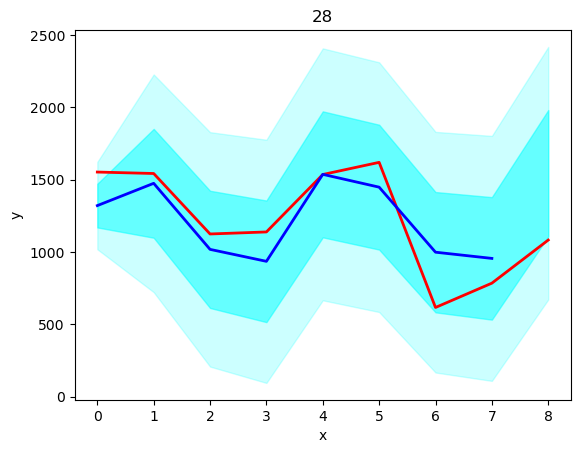

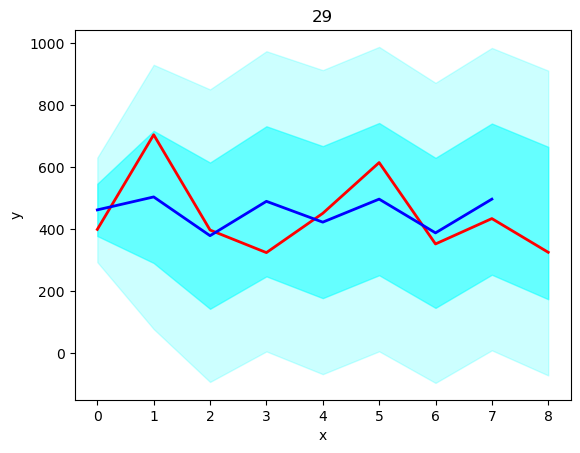

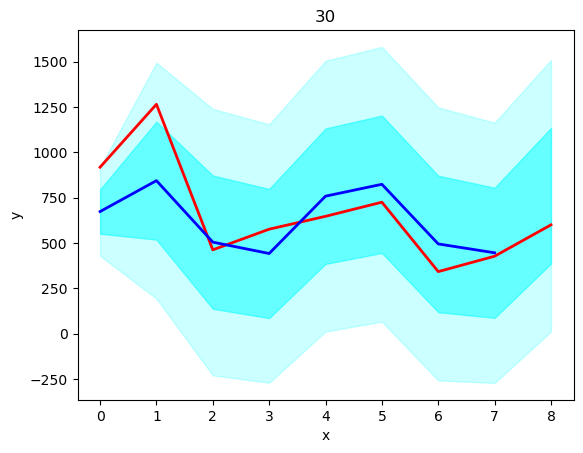

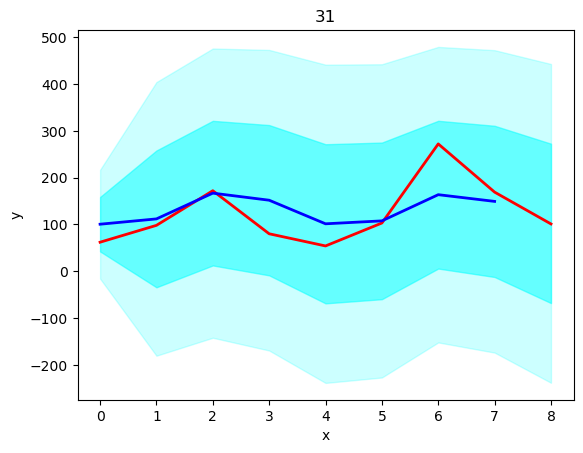

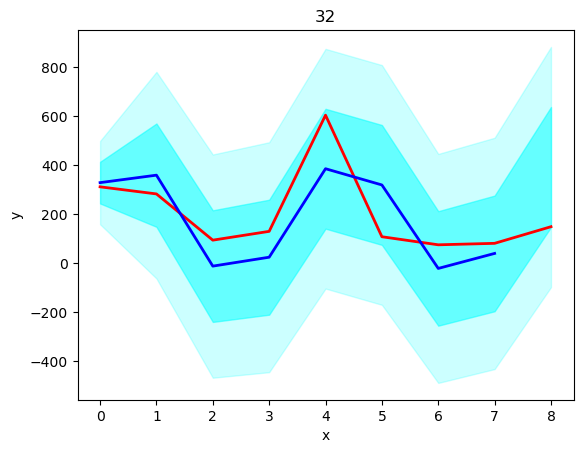

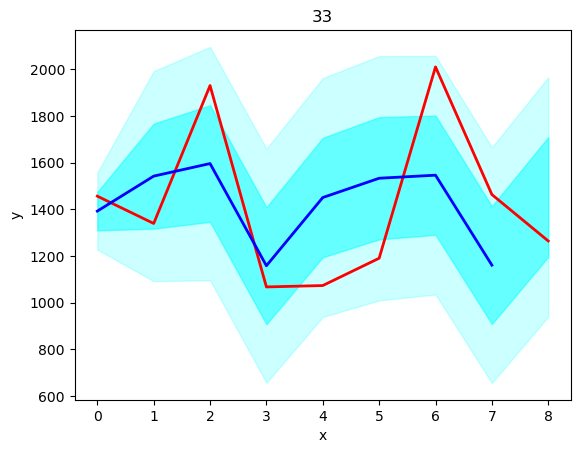

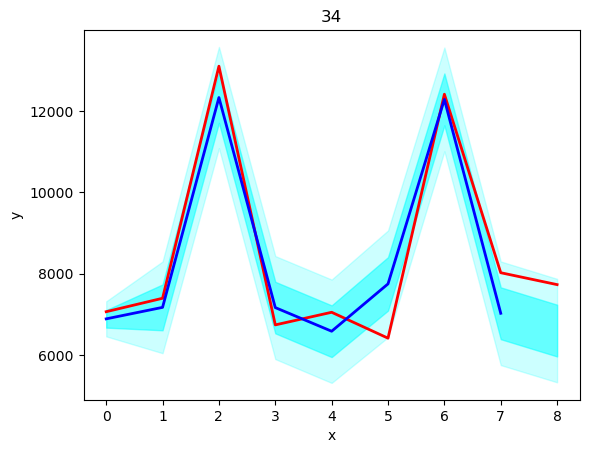

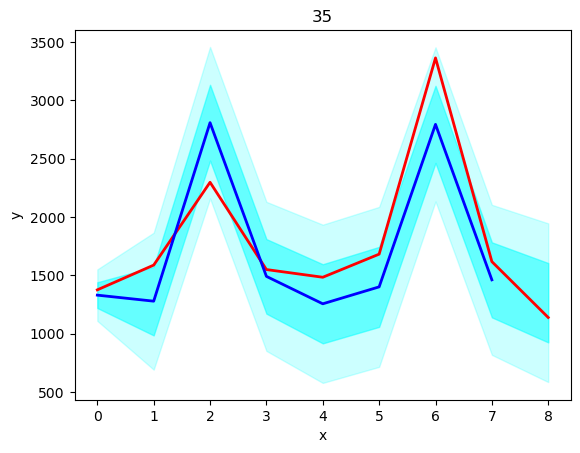

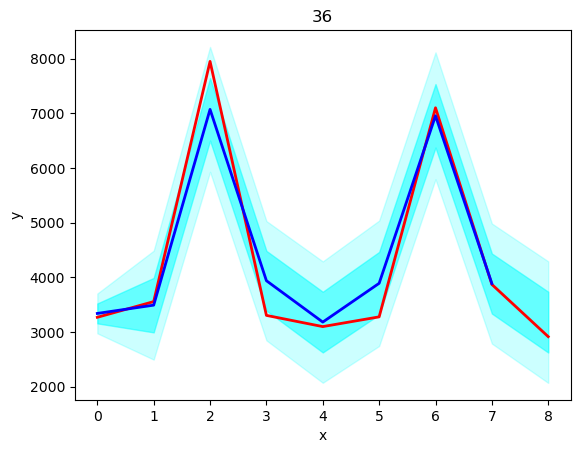

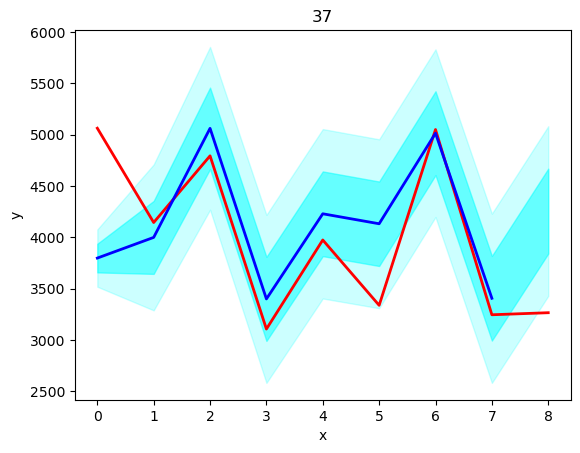

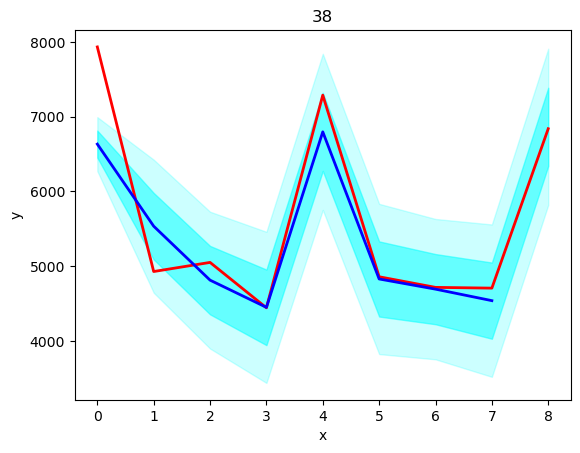

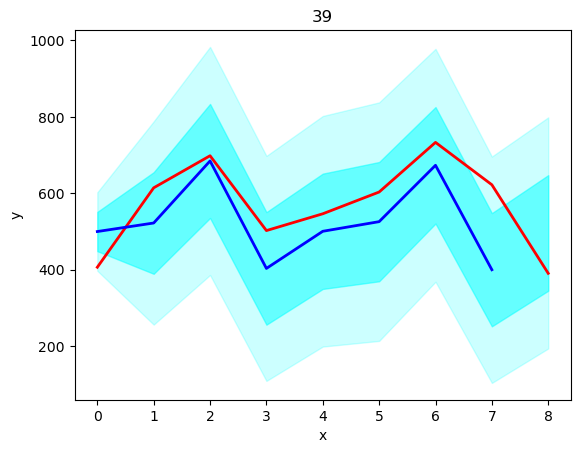

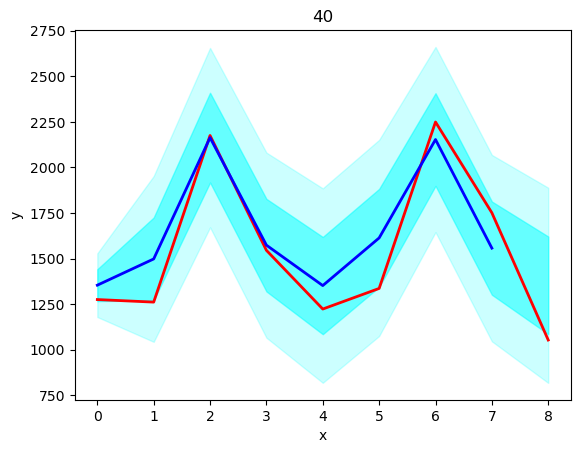

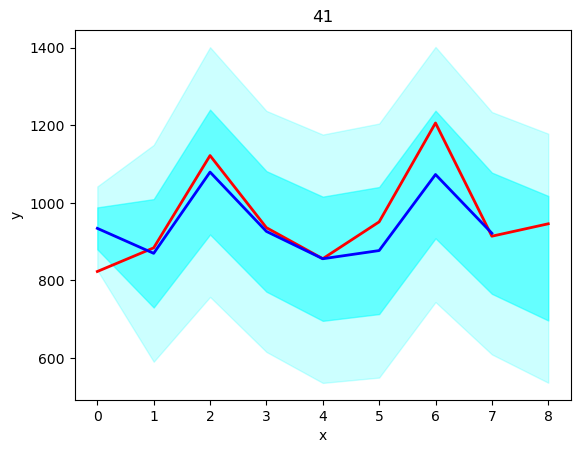

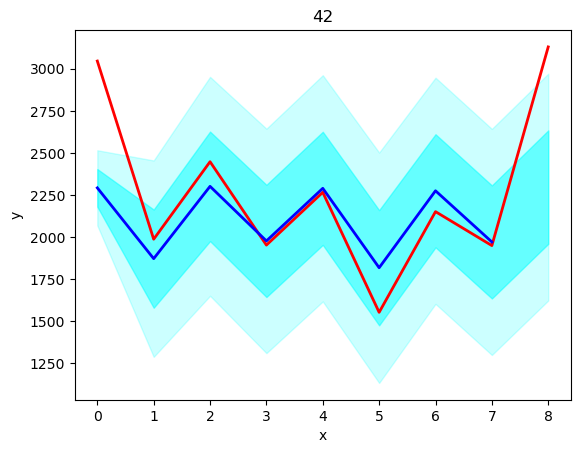

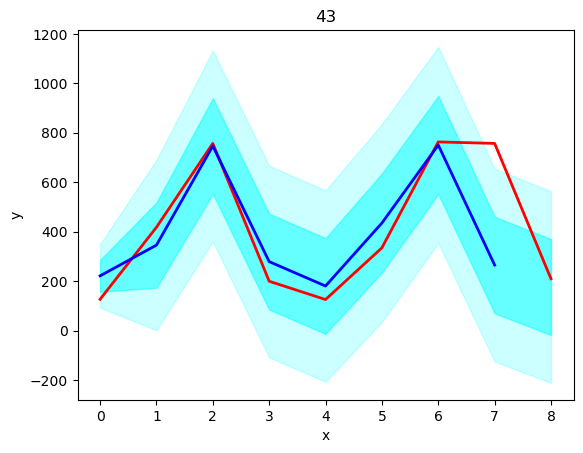

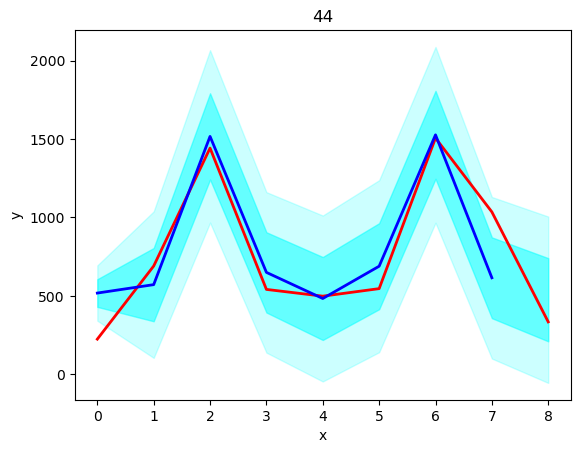

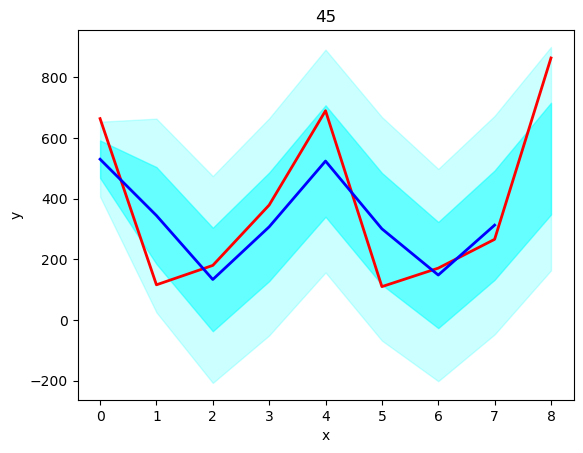

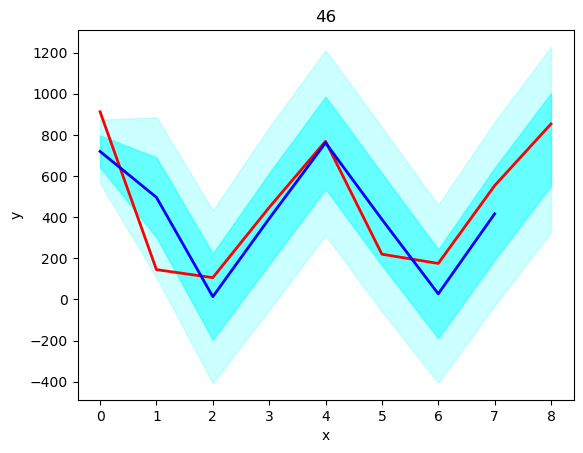

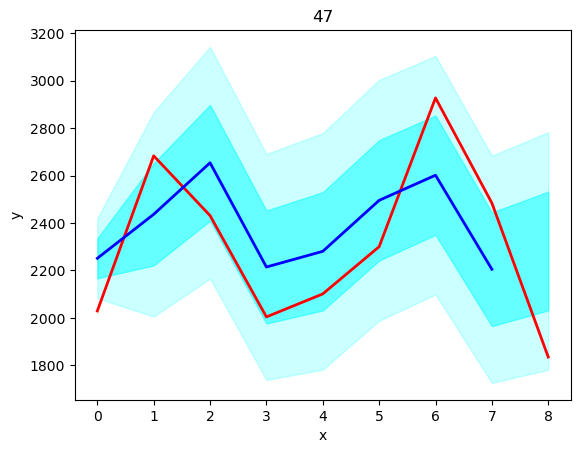

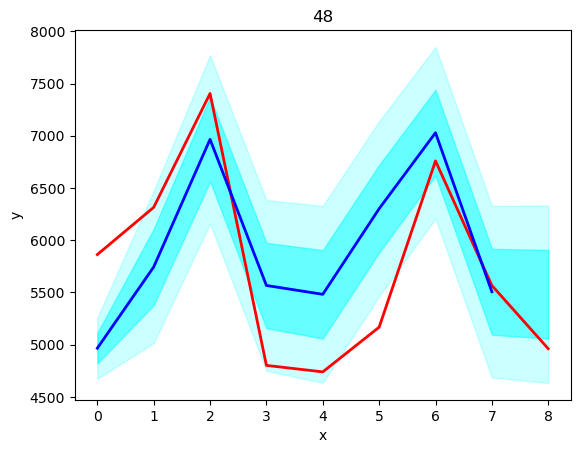

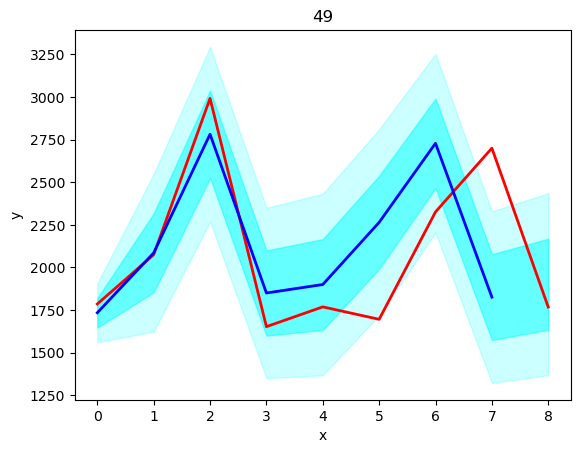

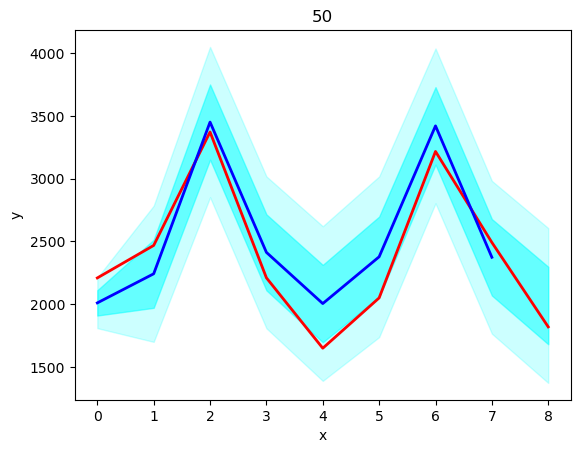

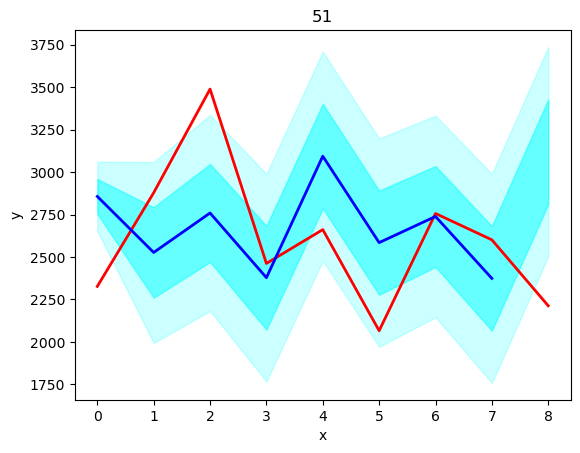

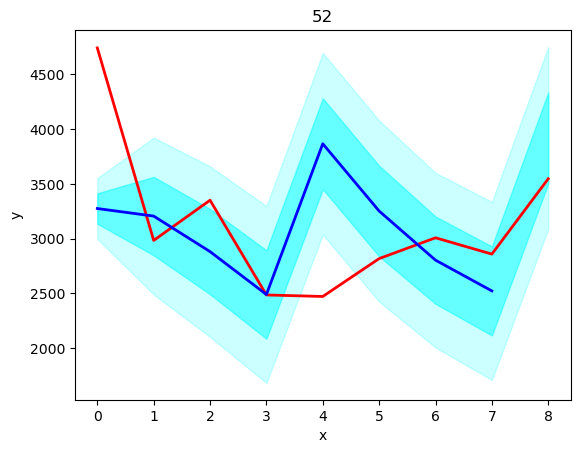

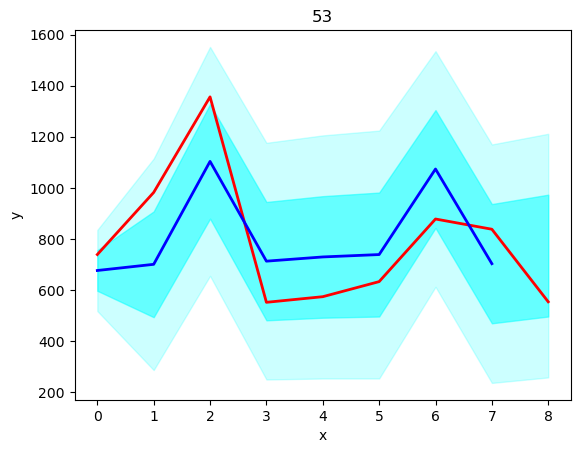

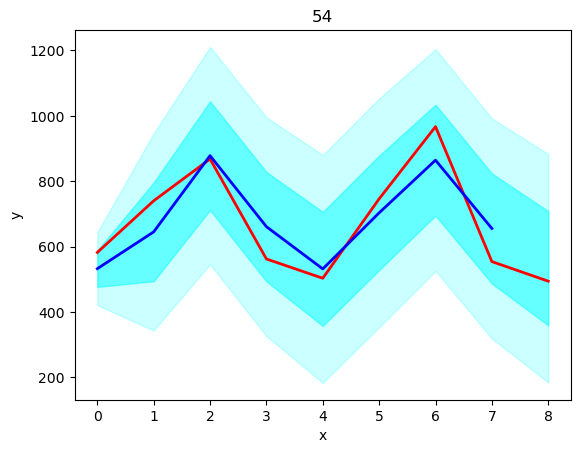

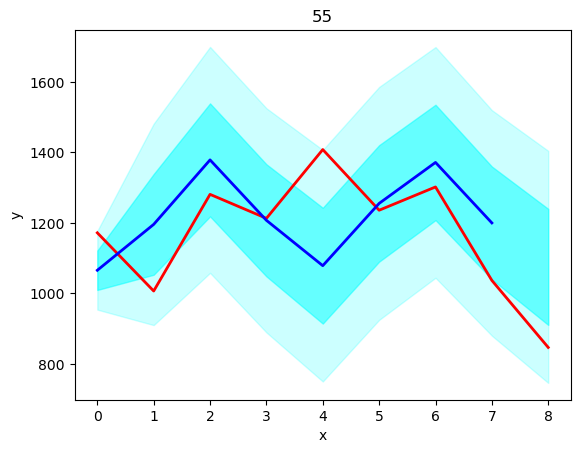

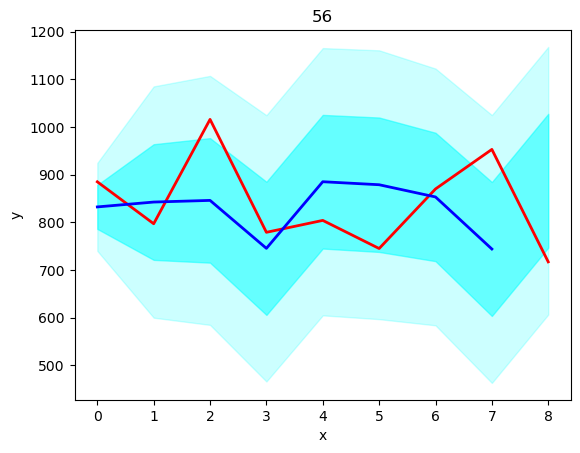

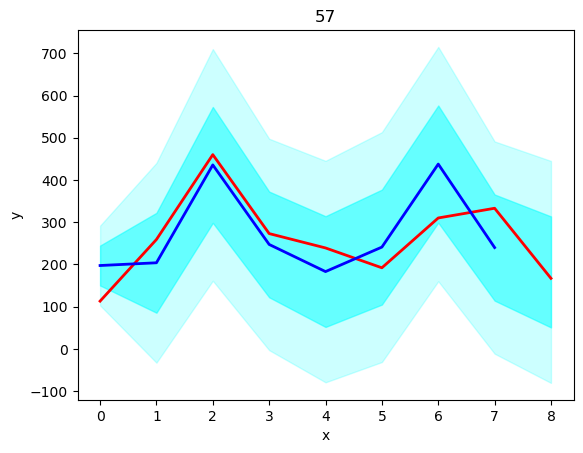

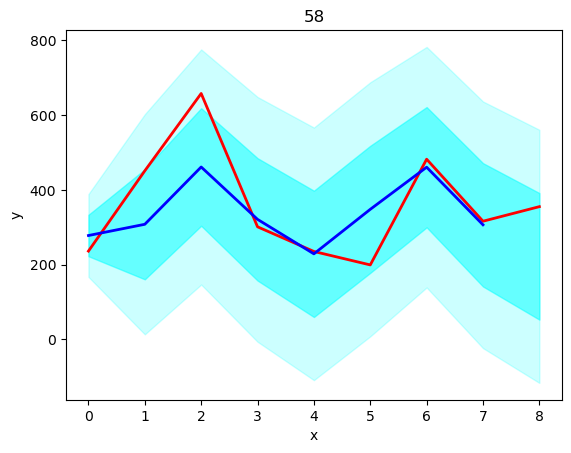

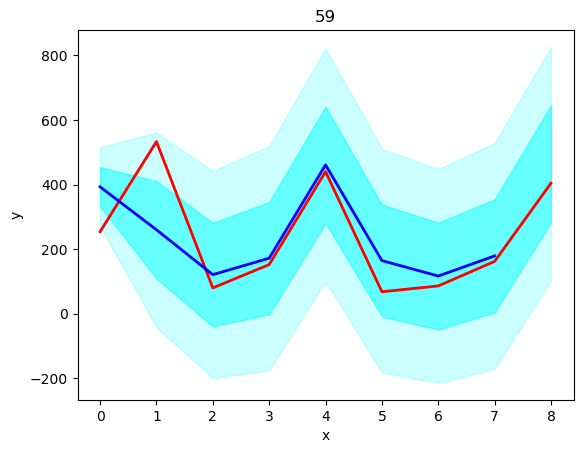

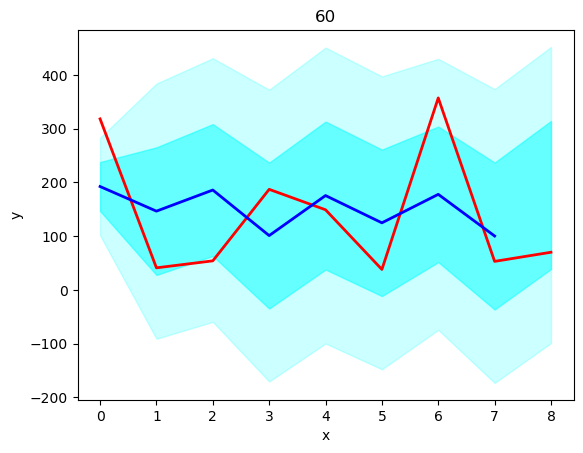

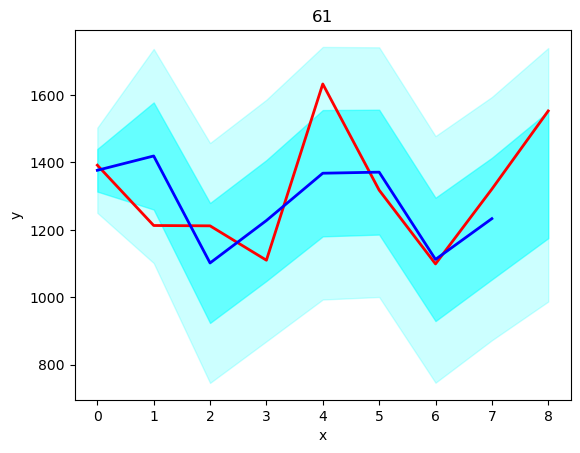

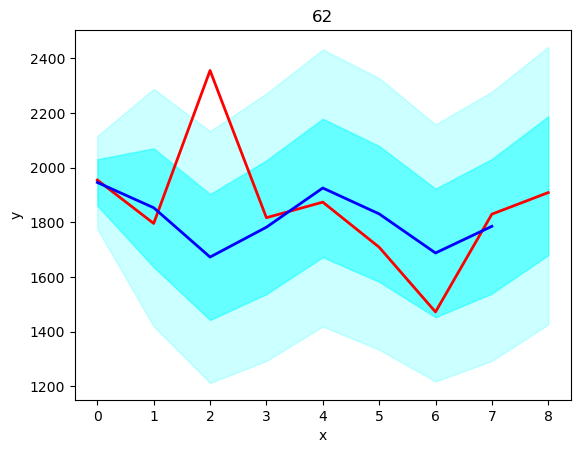

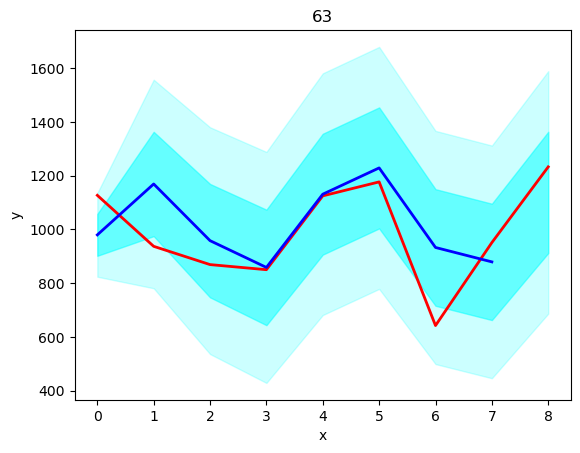

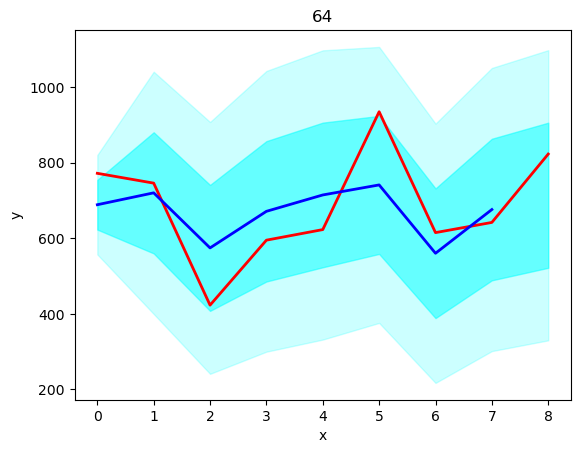

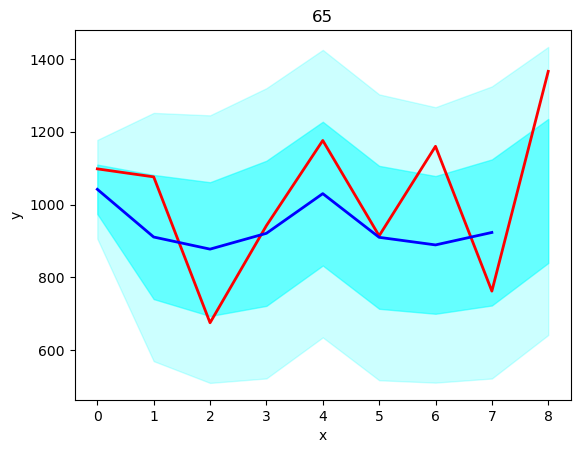

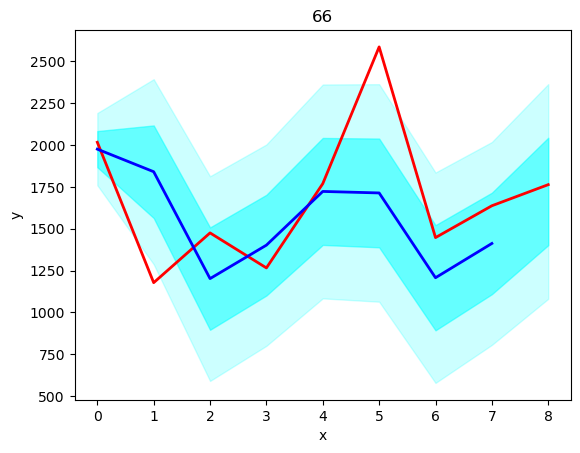

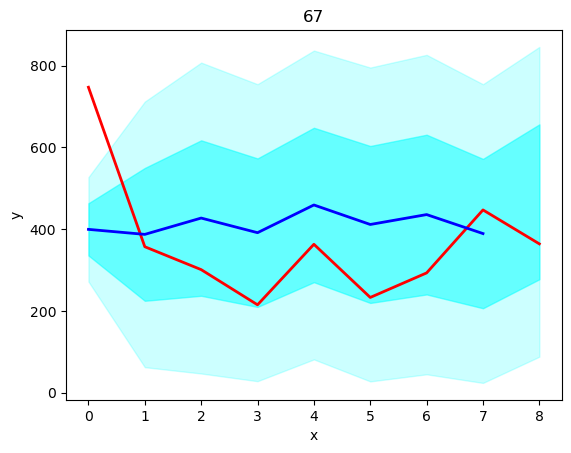

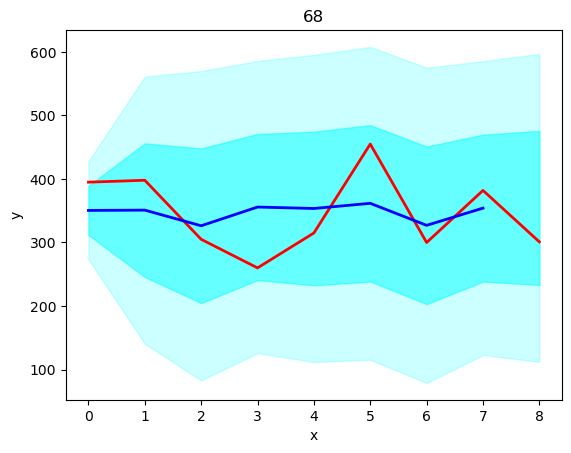

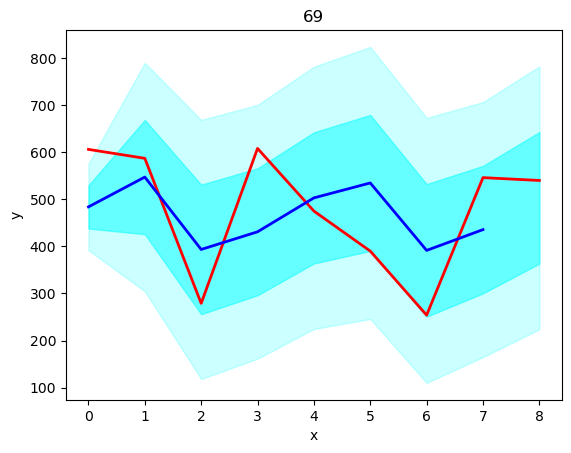

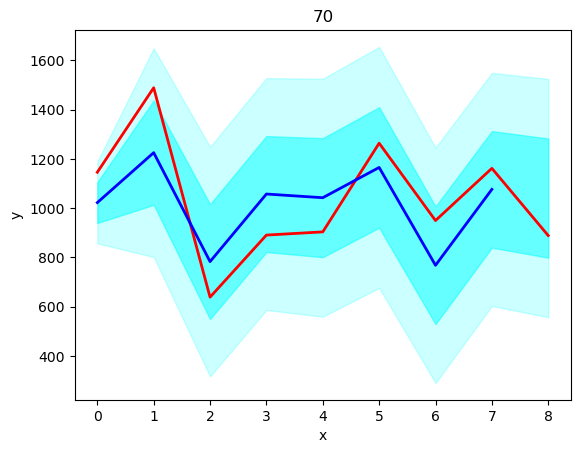

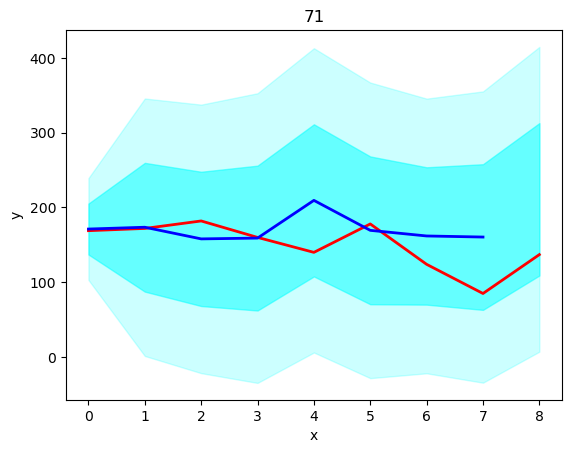

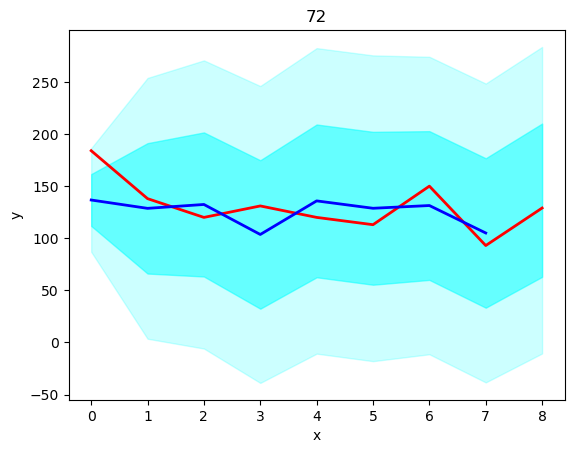

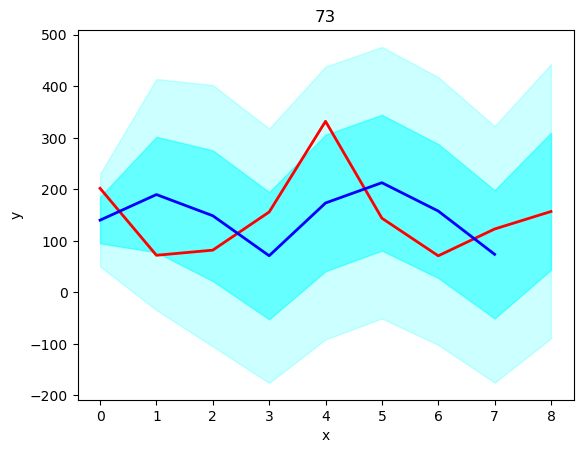

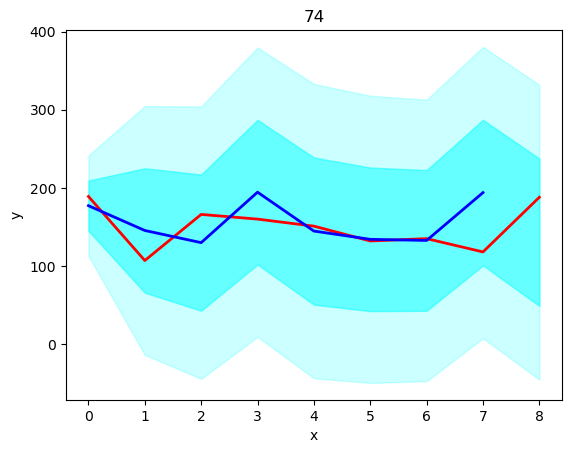

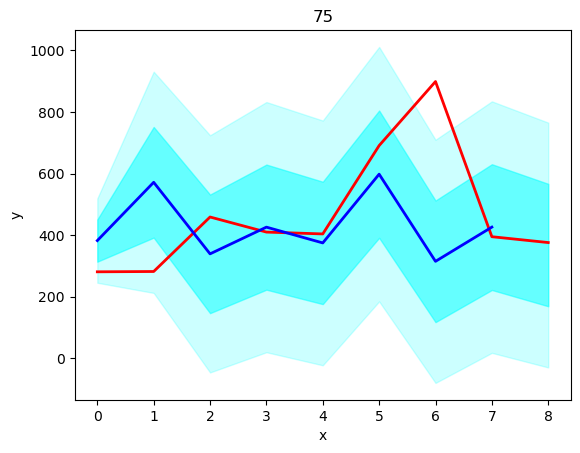

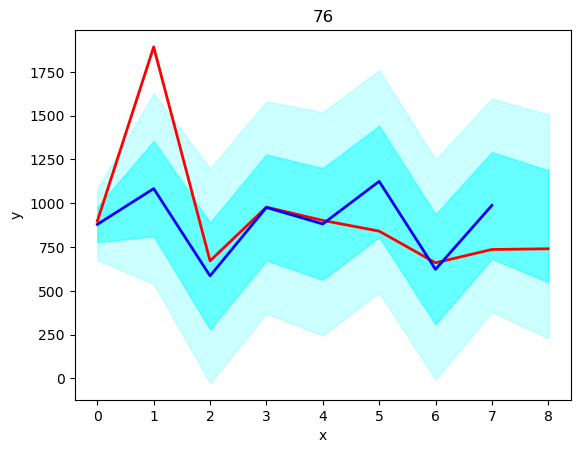

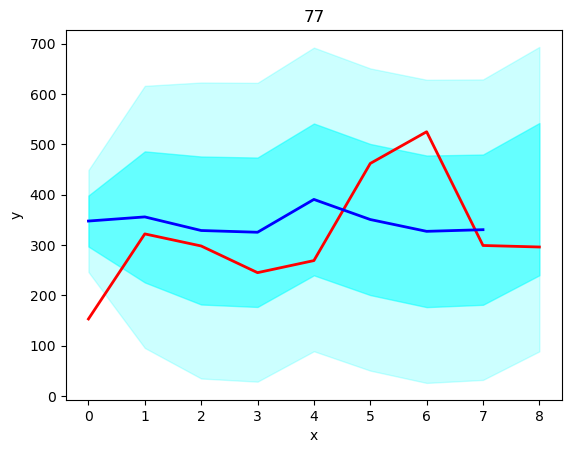

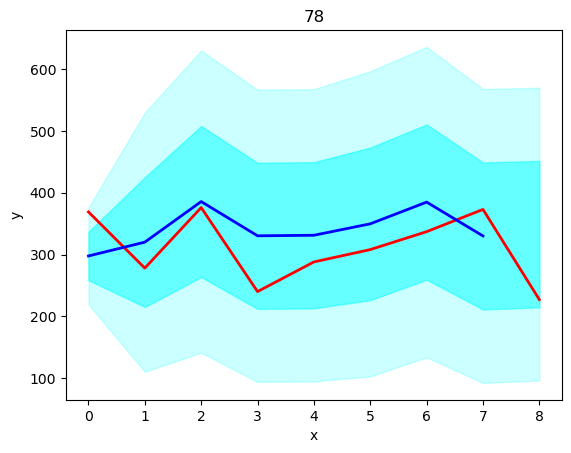

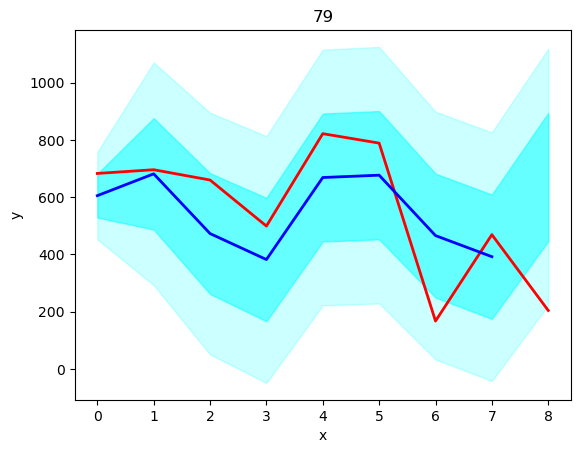

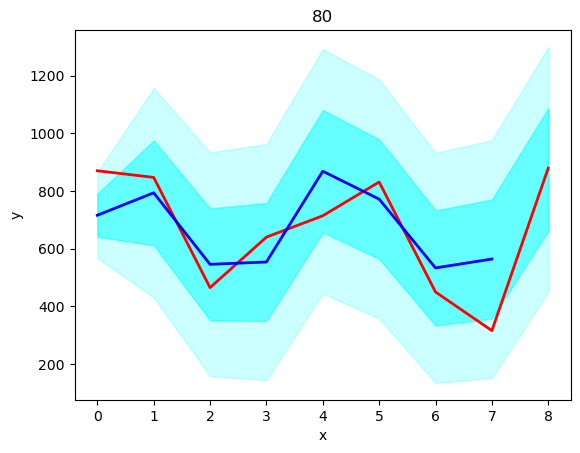

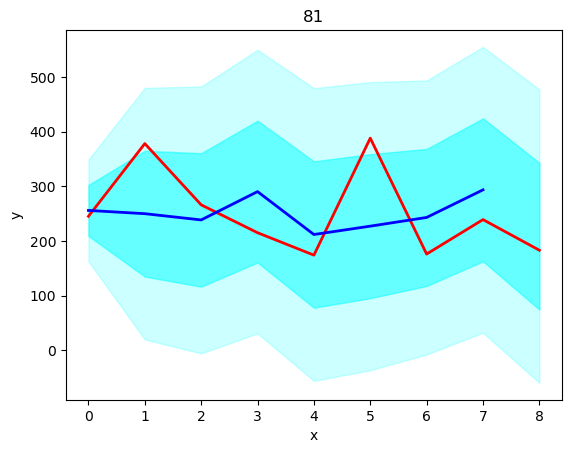

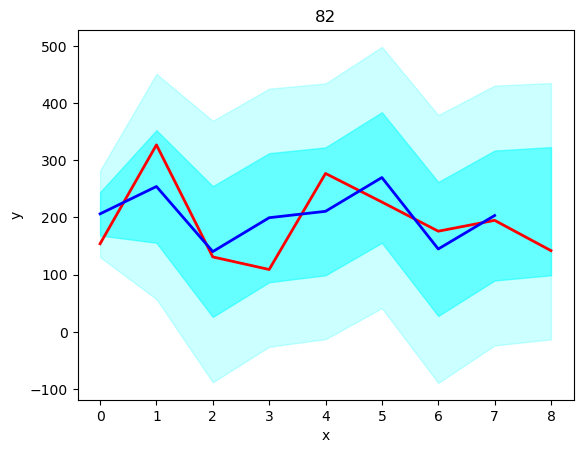

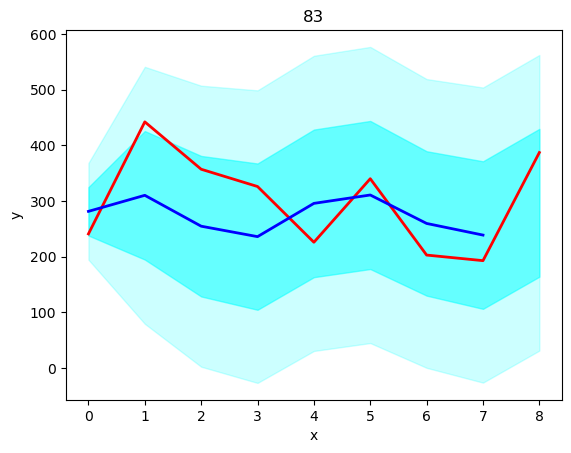

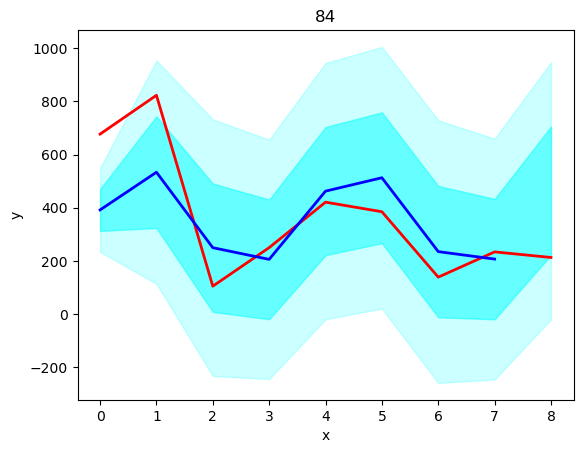

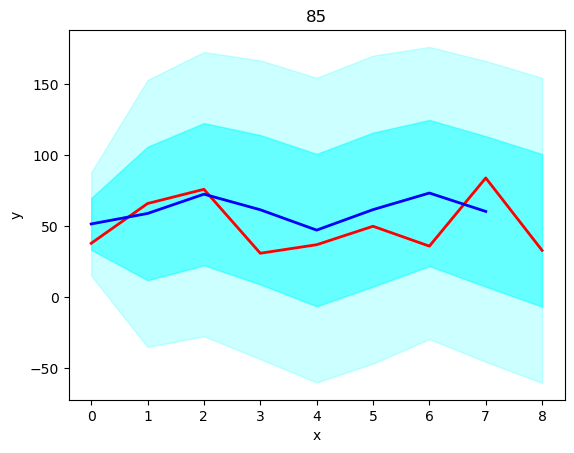

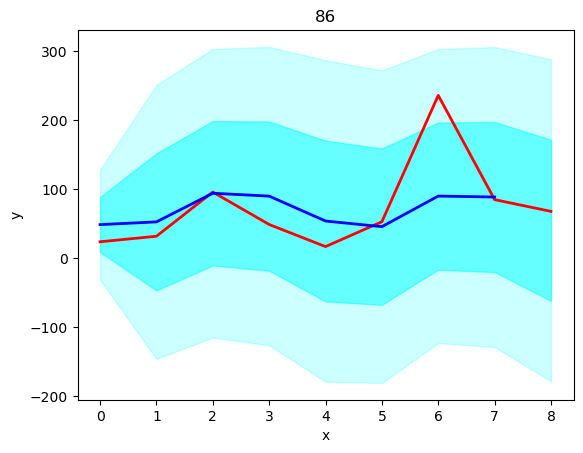

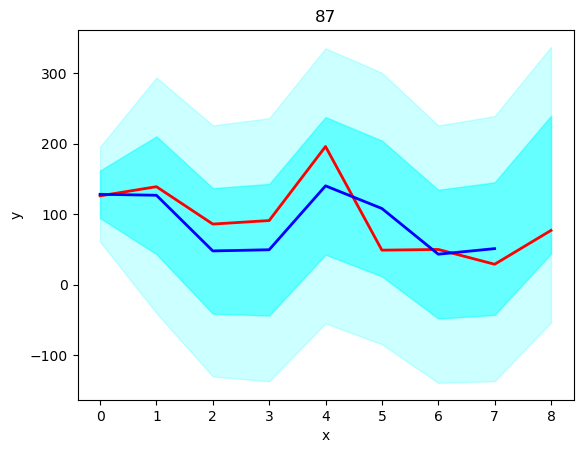

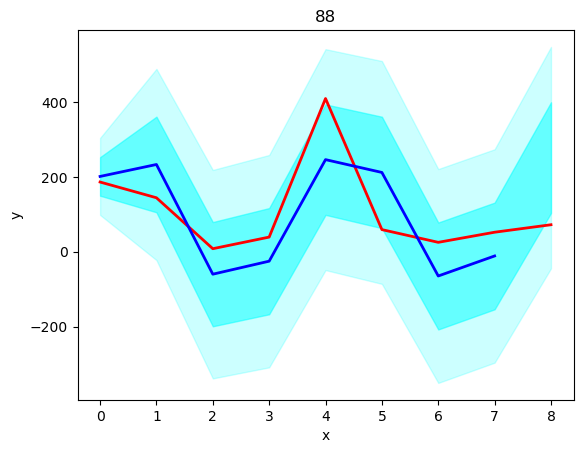

In [24]:
test_dataloader_iter = iter(test_dataloader)
for i in range(0, 1):
    test_batch = next(test_dataloader_iter)
    with torch.no_grad():
        input, target, covariates = utils.split_batch(test_batch)
        input, covariates = utils.scale(input, covariates)
        pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
        pred = utils.invert_scale(pred, True)
        loss = model.NLL(pred, target,AG)
        print("loss (prediction): {0}".format(loss))
        preds = pred[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        for i,j in zip(ht,range(len(ht))):
            preds[:, j:j+1, 0]=np.sum(preds[:, i[0]:i[1], 0:1],axis=1)
            preds[:, j:j+1, 1]=np.sum(preds[:, i[0]:i[1], 1:2],axis=1)
            
    for j in range(num_targets):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        target = targets[:, j]
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(target)), target, 'r', linewidth=2.0)
        plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
        plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0)
        plt.fill_between(np.arange(len(target)), pred - std, pred + std, color='cyan', alpha=0.5)
        plt.fill_between(np.arange(len(target)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
        plt.title(j)